<center>
<h2><b>Deep Learning (AI2100/AI5100/EE6380): Project</b> </h2>
<h3><i>Sensor-Based Human Activity Classification
Challenge</i></h3><br>
<h4><i>Dataset: PIRvision FoG presence detection</i></h4><br>
</center>

**Submitted by: Team 16**
#### **Sakshi Badole** : ***CS24MTECH11008***
#### **Sanskriti Agarwal** : ***CS24MTECH14002***
#### **Aviraj Antala** : ***CS24MTECH14011***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import math
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Function Definitions
### Rolling Window Split Functions, Dataset and Model Definitions, Training and Utility Functions

In [28]:
# Load data
df = pd.read_csv("pirvision_office_dataset2.csv")

In [5]:
def preprocess_datetime(df):
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['second'] = df['datetime'].dt.second
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df = df.drop(['Date', 'Time', 'datetime', 'hour', 'minute', 'second',
                  'day_of_week', 'day_of_month', 'month'], axis=1)
    return df

## Feature Visualization
We visualize the dataset features to understand their distributions, relationships, and importance for classification. Each visualization is accompanied by an explanation of its importance and justification for preprocessing steps based on the insights gained

In [30]:
# Load data
df = pd.read_csv("pirvision_office_dataset2.csv")
# Preprocess datetime
df = preprocess_datetime(df)

# Initialize visualization parameters
label_column = 'Label'
print("\n" + "="*60)
print(" DATASET VISUALIZATION AND FEATURE ANALYSIS")
print("="*60)

# Get feature categories
ts_cols = [col for col in df.columns if col.startswith('PIR')]
tab_cols = [col for col in df.columns if col not in ts_cols and col != label_column]
cyclic_cols = [col for col in tab_cols if '_sin' in col or '_cos' in col]
non_cyclic_tab_cols = [col for col in tab_cols if col not in cyclic_cols]

# Encode target for coloring
le = LabelEncoder()
y_encoded = le.fit_transform(df[label_column].values)
class_names = le.classes_
num_classes = len(class_names)
class_colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Dataset Overview
print(f"Dataset shape: {df.shape}")
print(f"Number of time series features: {len(ts_cols)}")
print(f"Number of tabular features: {len(tab_cols)}")
print(f"Number of classes: {num_classes} ({', '.join(map(str, class_names))})")
print(f"Class distribution: {df[label_column].value_counts().to_dict()}")


 DATASET VISUALIZATION AND FEATURE ANALYSIS
Dataset shape: (7651, 67)
Number of time series features: 55
Number of tabular features: 11
Number of classes: 3 (0, 1, 3)
Class distribution: {0: 6247, 1: 833, 3: 571}


### Preprocessing Justification:

- The class distribution output highlights potential imbalances, justifying the use of class weights in the model to handle uneven class representation.
- Identifying cyclic columns (e.g., hour_sin, hour_cos) confirms that preprocessing correctly transformed datetime features into a format suitable for modeling temporal patterns.

## ***Class Distribution Visualization***
Importance:

This plot shows the frequency of each class in the dataset, highlighting any class imbalances.

The percentage labels provide a clear view of each class's proportion, aiding in assessing the severity of imbalance.

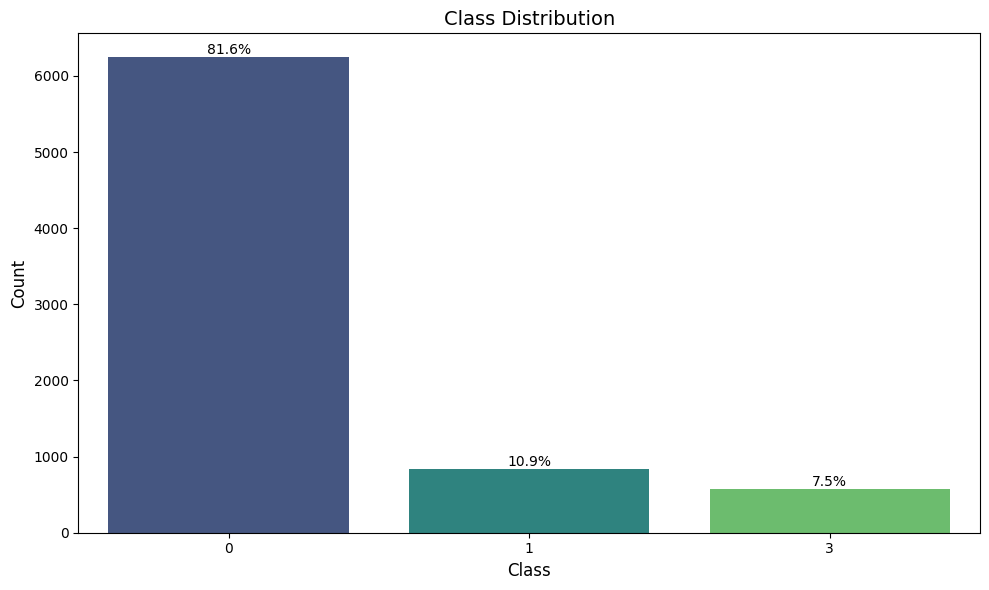

In [31]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=label_column, data=df, palette='viridis')
plt.title('Class Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Preprocessing Justification:

The plot reveals significant class imbalance:
    - Supports the preprocessing decision to compute class weights based on inverse frequency (class_weights in the training functions).
    
The visualization confirms that all classes are present, validating that the label encoding in preprocessing retains all class information.

------

## Time Series Features Visualization - Mean by Class
Importance:

- Displays the temporal patterns of PIR sensor readings for each class, showing how sensor values evolve over time.
- Helps identify whether different classes exhibit distinct temporal behaviors, which is crucial for justifying the use of a transformer model that captures sequential dependencies.
- Limiting to the first 200 samples and 20 sensors keeps the visualization manageable while still revealing key patterns.

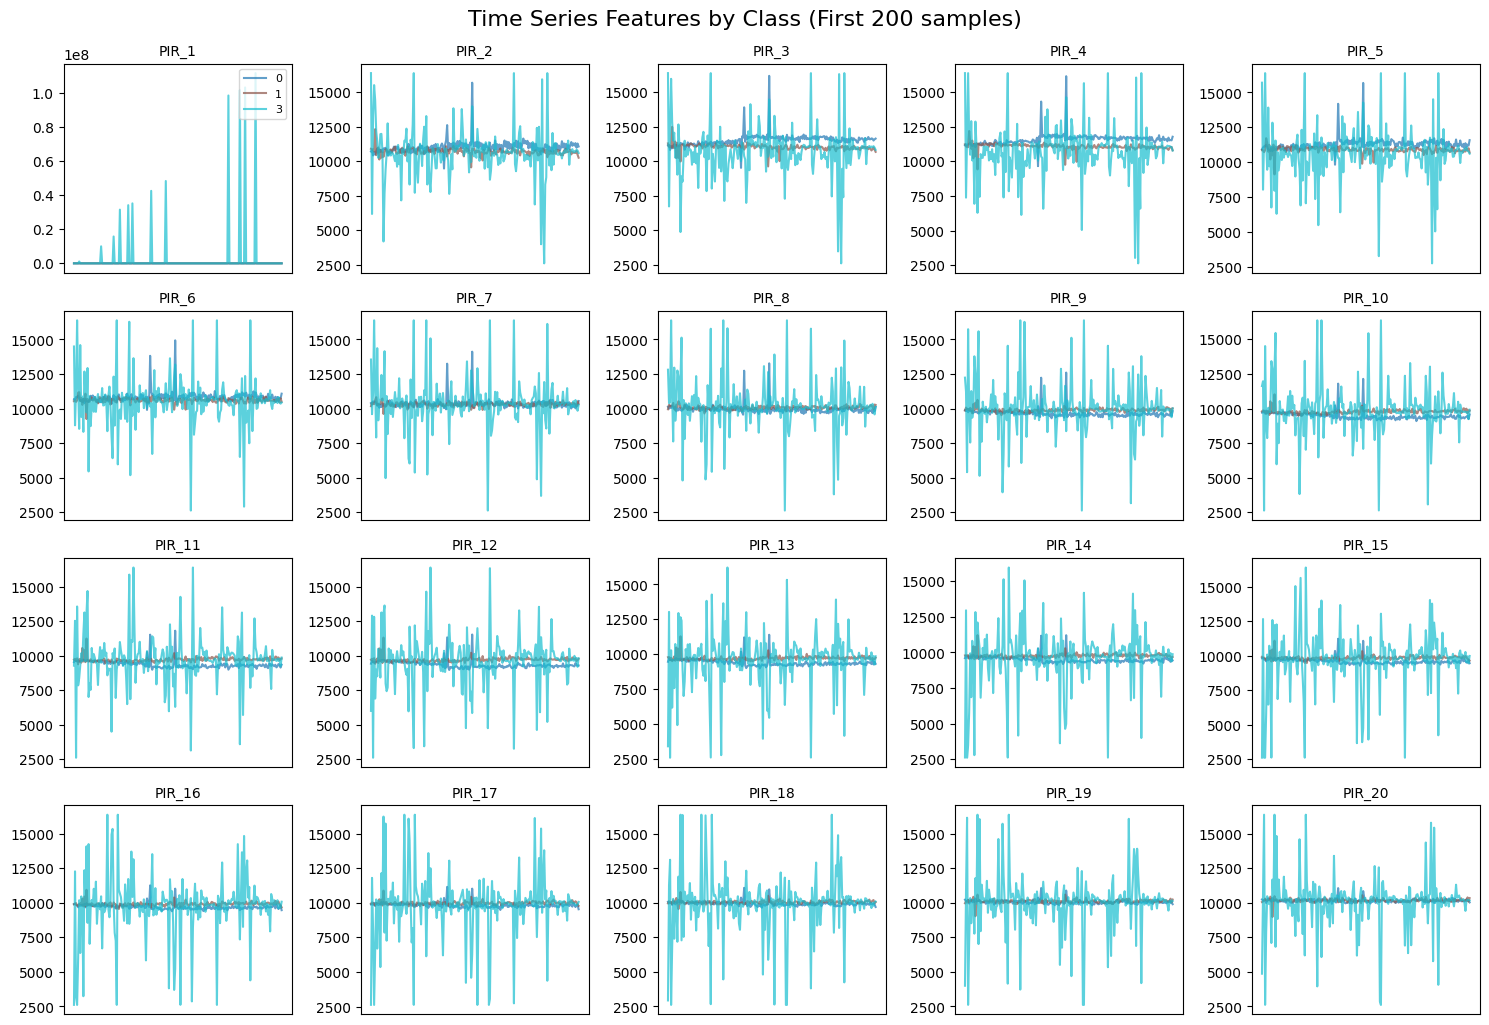

In [32]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(ts_cols[:min(20, len(ts_cols))]):  # Limit to 20 plots
    plt.subplot(4, 5, i+1)
    for j, cls in enumerate(class_names):
        cls_data = df[df[label_column] == cls][col]
        if len(cls_data) > 0:
            plt.plot(cls_data.values[:min(200, len(cls_data))], alpha=0.7, 
                     color=class_colors[j], label=cls if i == 0 else "")
    plt.title(f'{col}', fontsize=10)
    plt.xticks([])
    if i == 0:
        plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.suptitle('Time Series Features by Class (First 200 samples)', fontsize=16, y=1.02)
plt.show()

The distinct patterns across classes (e.g., spikes or trends) validate the inclusion of all PIR sensors without reduction, as each sensor may contribute unique temporal information. The use of standard scaling in preprocessing ensures these patterns are normalized, preventing any single sensor from dominating the transformer’s attention mechanism.

____

## PIR Sensor Correlation Matrix
Importance:

Visualizes correlations between PIR sensors to identify redundant or highly related sensors.
High correlations suggest that some sensors may capture similar information, supporting the use of a transformer’s attention mechanism to focus on relevant sensor interactions.
The heatmap format makes it easy to spot strong positive or negative relationships, guiding feature selection or dimensionality reduction decisions.

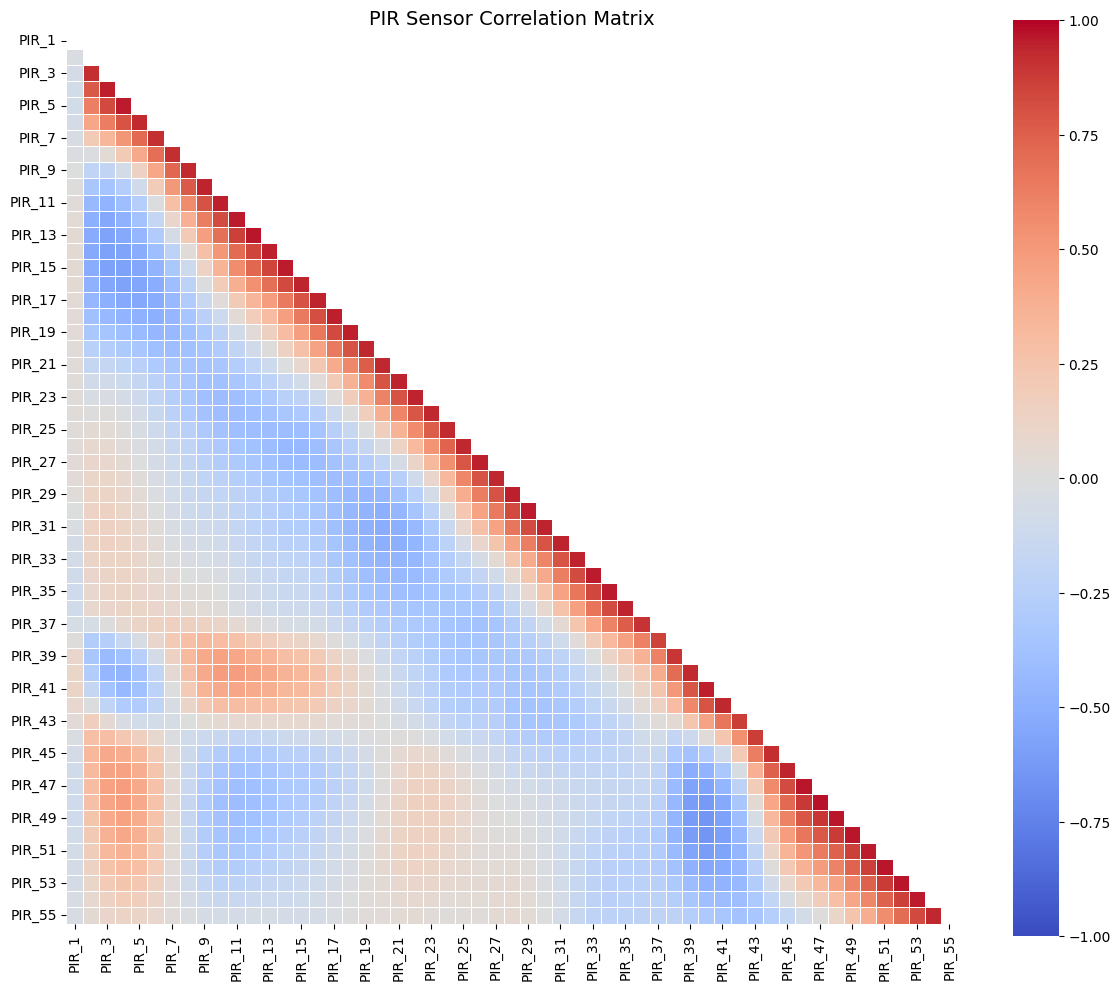

In [33]:
plt.figure(figsize=(12, 10))
try:
    ts_corr = df[ts_cols].corr()
    mask = np.triu(np.ones_like(ts_corr, dtype=bool))
    sns.heatmap(ts_corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
                annot=False, square=True, linewidths=.5)
    plt.title('PIR Sensor Correlation Matrix', fontsize=14)
except Exception as e:
    plt.text(0.5, 0.5, f"Could not generate correlation matrix: {str(e)}", 
            horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.show()

### Preprocessing Justification:
High correlations between sensors (red areas in the heatmap) indicate that raw PIR data may contain redundant information, justifying the use of standard scaling to normalize sensor values and prevent any single sensor from dominating the model. The absence of extreme correlations suggests that all sensors contribute unique information, supporting the decision to include all PIR columns without feature reduction in preprocessing.

----

## Class-Specific PIR Sensor Patterns
Importance:

- Shows the intensity and variation of PIR sensor readings across time for each class using a heatmap.
- Helps confirm whether classes have unique sensor activation patterns, which is essential for classification tasks.
- The visualization highlights temporal and spatial (across sensors) differences, supporting the model’s architecture that processes both dimensions.

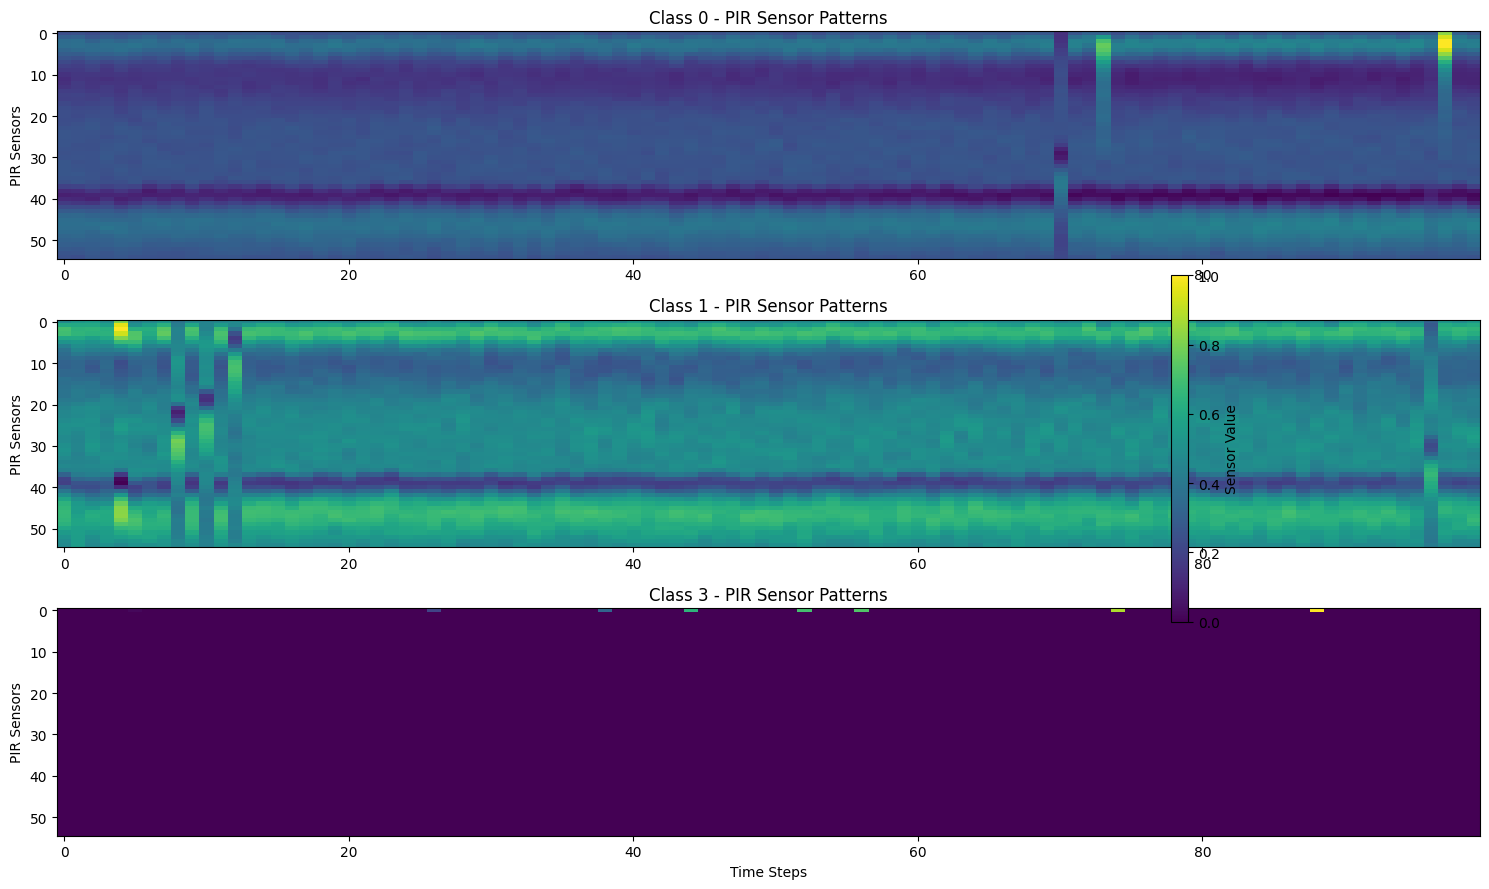

In [34]:
fig = plt.figure(figsize=(15, num_classes * 3))
gs = gridspec.GridSpec(num_classes, 1)

for i, cls in enumerate(class_names):
    ax = plt.subplot(gs[i])
    cls_data = df[df[label_column] == cls][ts_cols].iloc[:min(100, len(df[df[label_column] == cls]))]
    if len(cls_data) > 0:
        im = ax.imshow(cls_data.T, aspect='auto', cmap='viridis')
        ax.set_title(f'Class {cls} - PIR Sensor Patterns', fontsize=12)
        ax.set_ylabel('PIR Sensors')
        if i == num_classes - 1:
            ax.set_xlabel('Time Steps')
    else:
        ax.text(0.5, 0.5, f'No data for class {cls}', 
                horizontalalignment='center', verticalalignment='center')

fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gcf().axes, shrink=0.5, label='Sensor Value')
plt.tight_layout()
plt.show()

### Preprocessing Justification:
The distinct heatmap patterns for each class (e.g., intensity variations) validate the retention of all PIR sensors in preprocessing, as they capture class-specific spatial-temporal signatures. Standard scaling ensures these patterns are comparable across sensors, enhancing the transformer’s ability to learn from them.

---

## Tabular Feature Analysis - Boxplots
- Importance:

    - Boxplots show the distribution of non-cyclic tabular features across classes, revealing differences in central tendency and spread.
    - Helps assess whether these features are discriminative, justifying their inclusion in the model alongside time series data.

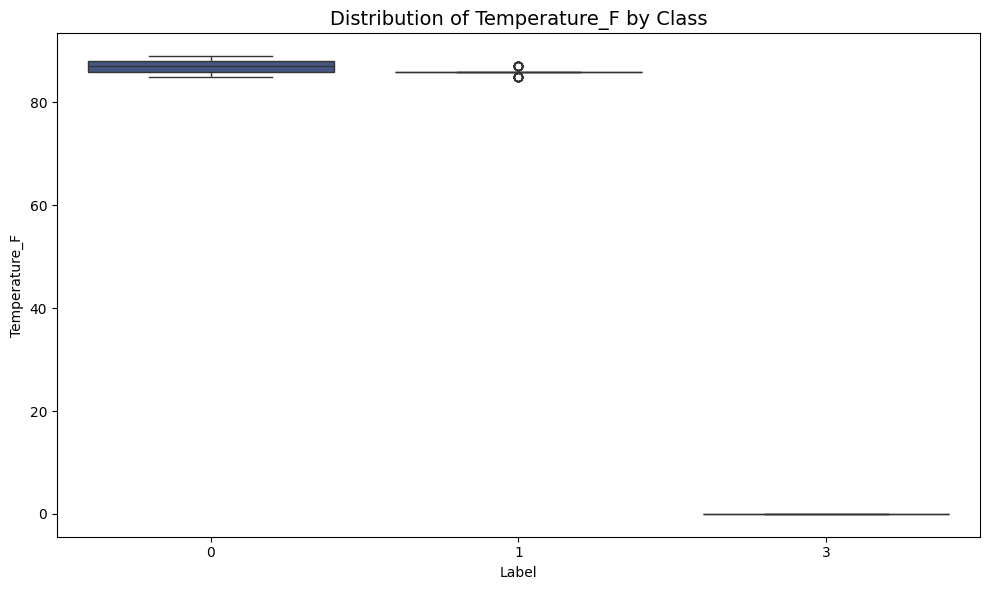

In [35]:
for col in non_cyclic_tab_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=label_column, y=col, data=df, palette='viridis')
    plt.title(f'Distribution of {col} by Class', fontsize=14)
    plt.tight_layout()
    plt.show()

### Preprocessing Justification:
Differences in boxplot medians or spreads across classes (e.g., for Temperature_F) justify retaining these features, as they provide additional discriminative power. The lack of extreme outliers supports the use of standard scaling to normalize these features for integration with time series data in the model.

---

## Cyclic Features Visualization - Polar Plots
- Importance
    - The polar plots confirm that cyclic encoding (sine and cosine transformations) effectively captures the periodic nature of temporal features, as classes show distinct distributions around the circle
    - This visualization supports the preprocessing decision to use sine/cosine transformations instead of raw temporal values, as linear representations (e.g., hour 23 vs. 0) would fail to capture proximity in cyclic time.

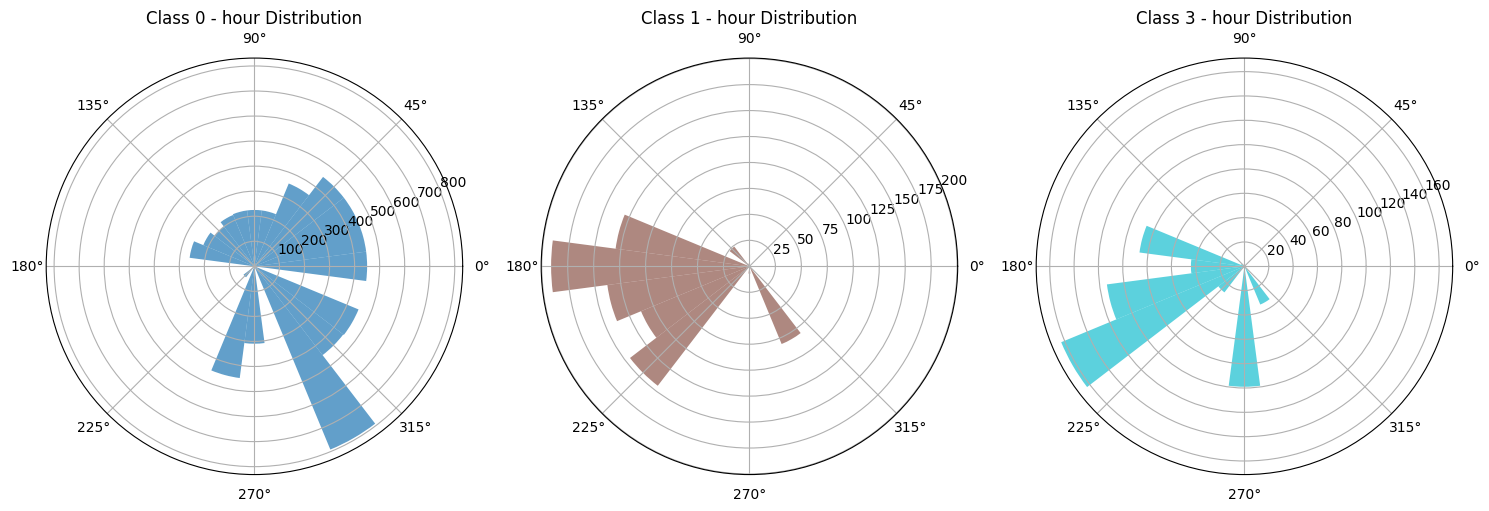

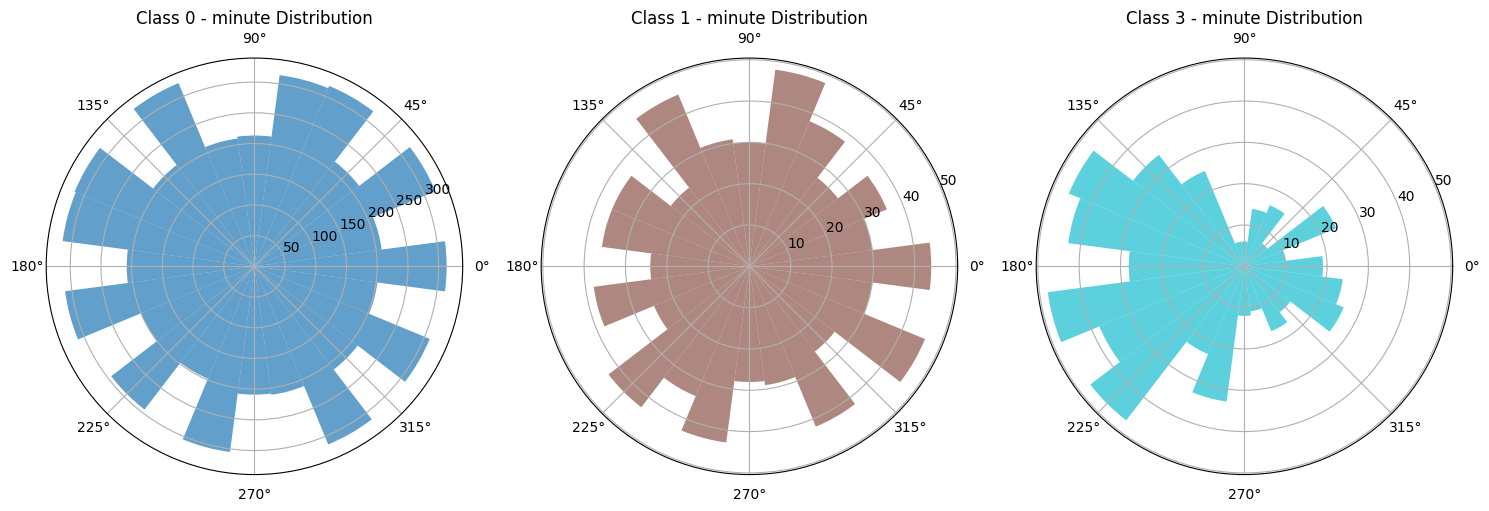

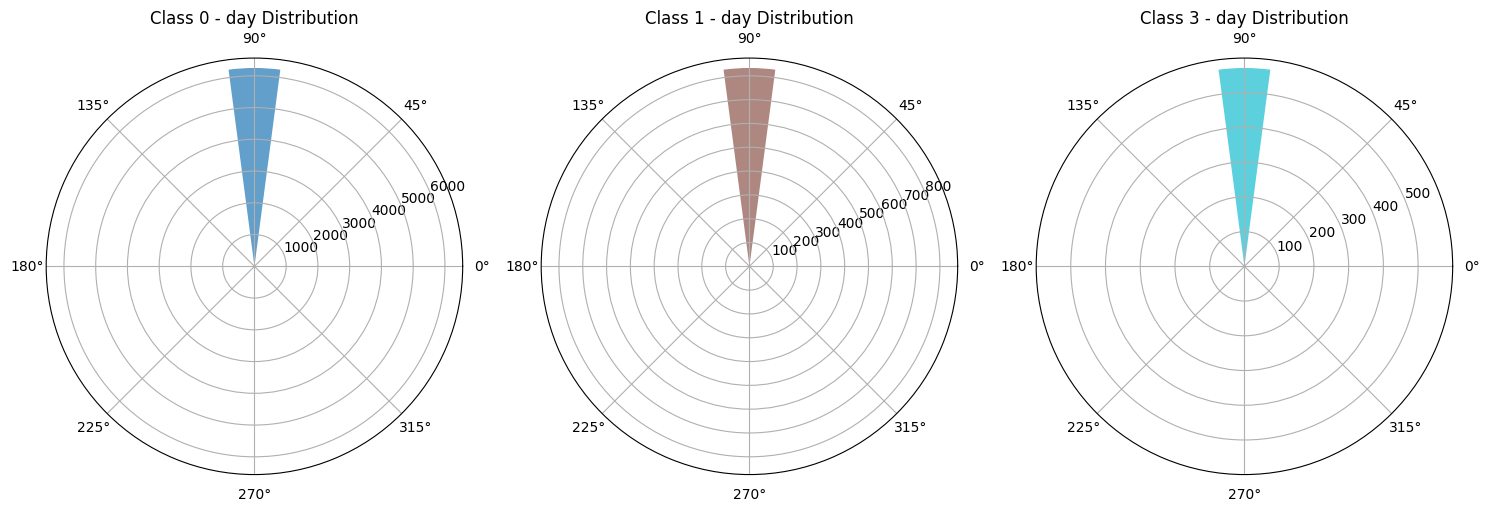

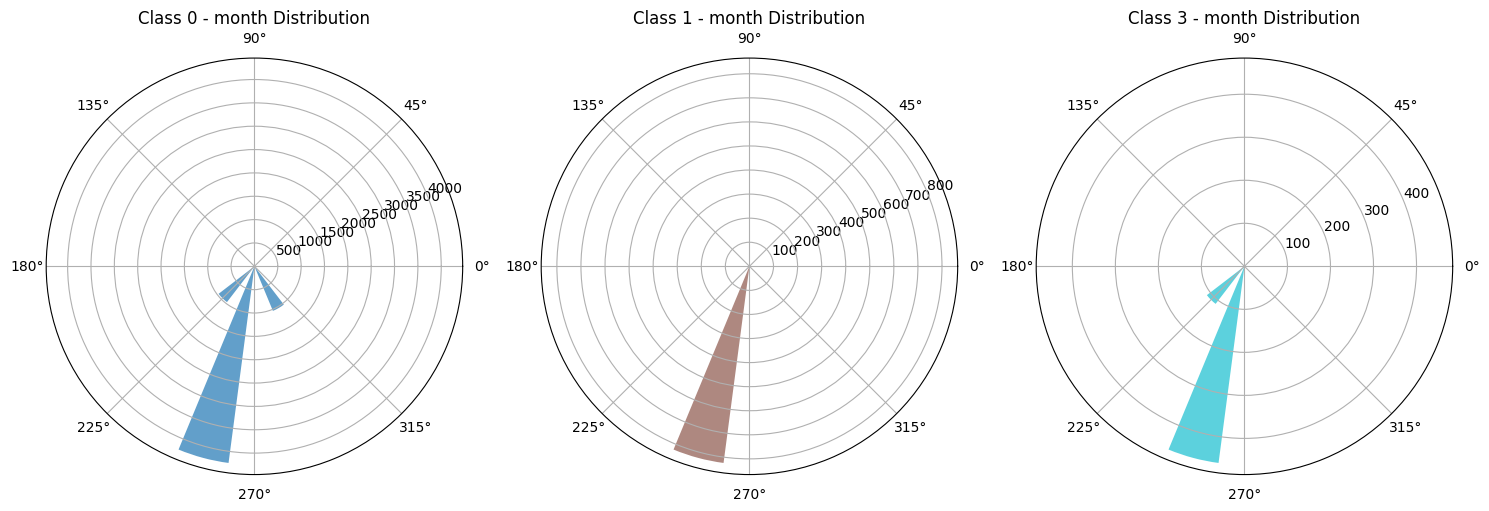

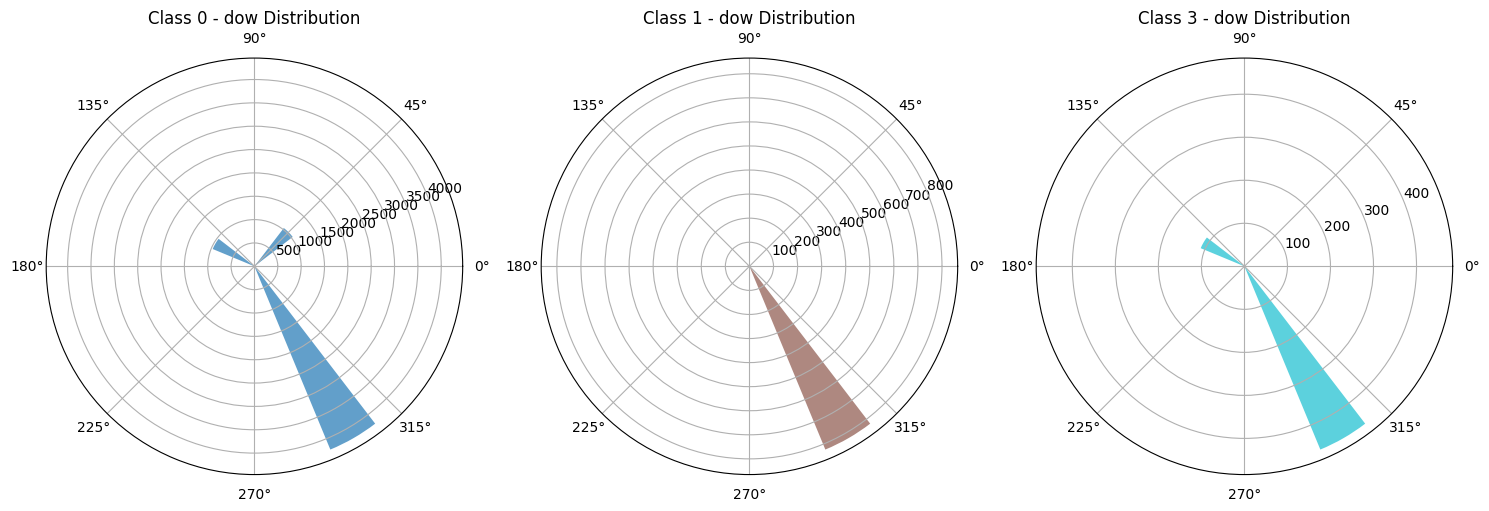

In [36]:
# Group cyclic features by their type (hour, minute, day, month, dow)
cyclic_types = {}
for col in cyclic_cols:
    prefix = col.split('_')[0]
    if prefix not in cyclic_types:
        cyclic_types[prefix] = []
    cyclic_types[prefix].append(col)

for prefix, cols in cyclic_types.items():
    if len(cols) >= 2:  # We need at least sin and cos
        sin_col = [col for col in cols if 'sin' in col][0] if any('sin' in col for col in cols) else None
        cos_col = [col for col in cols if 'cos' in col][0] if any('cos' in col for col in cols) else None
        
        if sin_col and cos_col:
            plt.figure(figsize=(15, 5))
            for i, cls in enumerate(class_names):
                plt.subplot(1, num_classes, i+1, projection='polar')
                cls_data = df[df[label_column] == cls]
                if len(cls_data) > 0:
                    # Convert sin, cos to angle and plot on polar
                    angles = np.arctan2(cls_data[sin_col], cls_data[cos_col])
                    # Plot histogram in polar coordinates
                    hist, bins = np.histogram(angles, bins=24, range=(-np.pi, np.pi))
                    width = (bins[1] - bins[0])
                    plt.bar(bins[:-1], hist, width=width, alpha=0.7, color=class_colors[i])
                plt.title(f'Class {cls} - {prefix} Distribution', fontsize=12)
            
            plt.tight_layout()
            plt.show()

### Preprocessing Justification:
The distinct polar distributions for each class (e.g., hour peaks) validate the cyclic encoding of datetime features (hour_sin, hour_cos, etc.), ensuring temporal periodicity is preserved for the transformer model. This justifies dropping raw temporal columns (e.g., hour) in preprocessing.

------

## Feature Importance Analysis - ANOVA F-value
- Importance:

    - Ranks features by their ANOVA F-values, indicating which features are most discriminative across classes.
    - Helps prioritize features for modeling and justifies the inclusion of both time series and tabular features if both types appear in the top ranks.
    - The bar plot makes it easy to compare feature importance, guiding model architecture decisions.

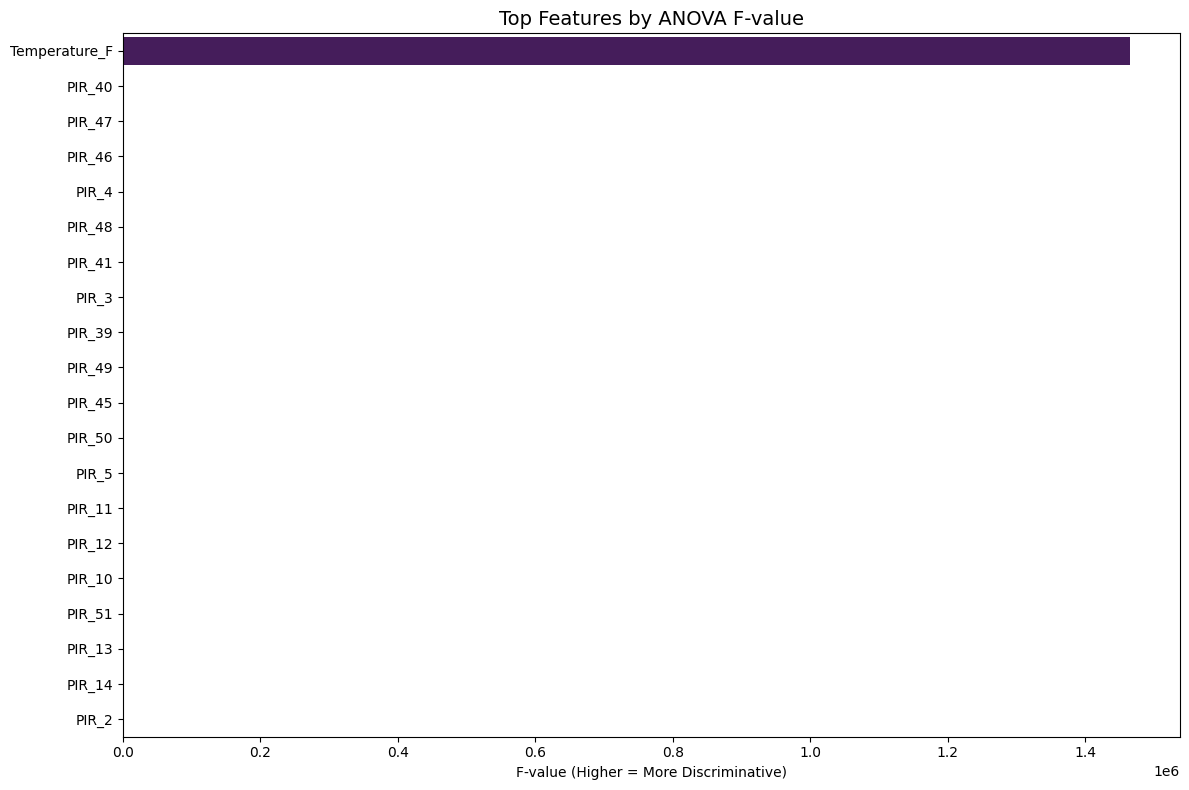

In [37]:
# ANOVA F-value for feature importance
f_values = {}
for col in ts_cols + non_cyclic_tab_cols:
    try:
        groups = [df[df[label_column] == cls][col].values for cls in class_names 
                 if len(df[df[label_column] == cls]) > 0]
        if len(groups) >= 2:  # Need at least 2 groups for ANOVA
            f_val, p_val = stats.f_oneway(*groups)
            f_values[col] = f_val if not np.isnan(f_val) else 0
        else:
            f_values[col] = 0
    except Exception:
        f_values[col] = 0

# Sort and plot top 20 features by F-value
if f_values:
    sorted_features = sorted(f_values.items(), key=lambda x: x[1], reverse=True)[:min(20, len(f_values))]
    plt.figure(figsize=(12, 8))
    feat_names, feat_scores = zip(*sorted_features)
    sns.barplot(x=list(feat_scores), y=list(feat_names), palette='viridis')
    plt.title('Top Features by ANOVA F-value', fontsize=14)
    plt.xlabel('F-value (Higher = More Discriminative)')
    plt.tight_layout()
    plt.show()

----

## Dimensionality Reduction Visualization - PCA

- The PCA plot visualizes the two principal components of the time series features, revealing the variance structure and potential class separability in a reduced dimensional space. 
- The plot indicates that a single dominant component (PC1) captures nearly all variance (100%), with PC2 contributing minimally. The lack of clear class separation (e.g., classes 0, 1, and 3 overlap significantly) suggests that linear dimensionality reduction alone may not effectively distinguish classes, highlighting the need for a non-linear model like a transformer to capture more complex patterns.

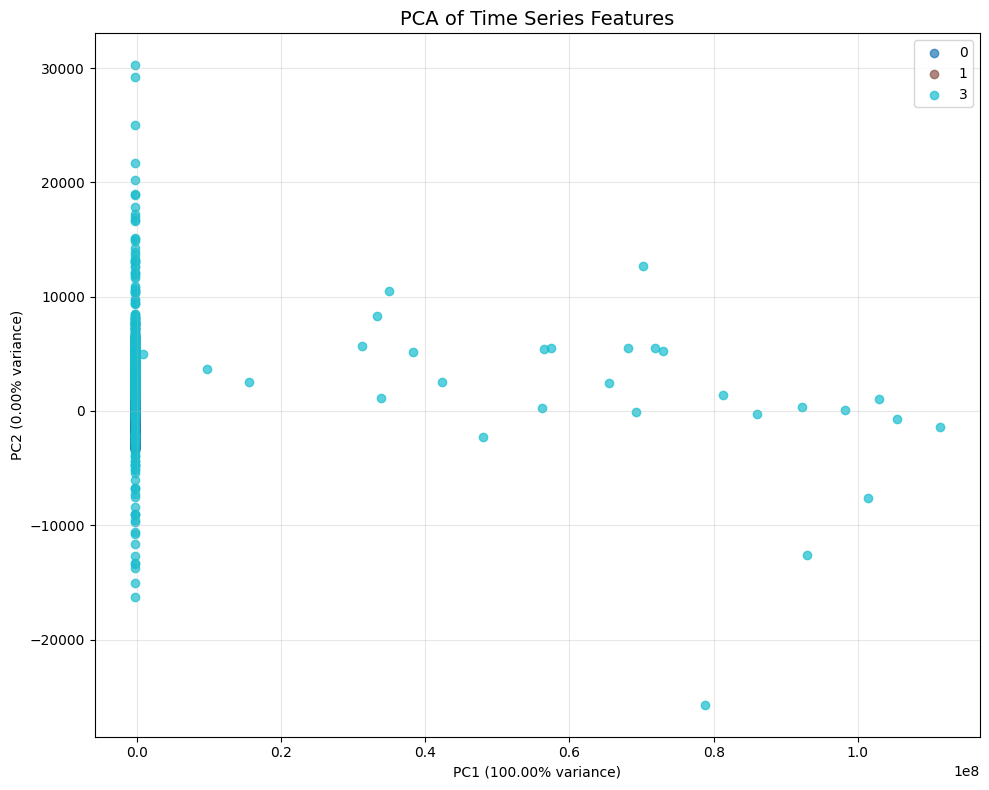

In [38]:
try:
    pca = PCA(n_components=2)
    ts_data = df[ts_cols].values
    ts_data_flat = ts_data.reshape(len(df), -1)
    ts_pca = pca.fit_transform(ts_data_flat)
    
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(class_names):
        mask = df[label_column] == cls
        plt.scatter(ts_pca[mask, 0], ts_pca[mask, 1], 
                   alpha=0.7, label=cls, color=class_colors[i])
    plt.title(f'PCA of Time Series Features', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not perform PCA: {str(e)}")

### Preprocessing Justification:
The dense clustering and lack of separation in the PCA plot validate the retention of all PIR sensors, as the high variance along PC1 indicates that the raw time series data contains rich information that linear methods cannot fully disentangle. The use of standard scaling prior to PCA ensures that all sensors contribute equally to the variance, preventing any single sensor from skewing the principal components. This preprocessing step is critical for the transformer model to leverage the full complexity of the data.

------

## Dimensionality Reduction Visualization - t-SNE
- Importance:
    - It highlights the partial clustering (e.g., class 0 separation) and overlap, indicating non-linear structure that a transformer can exploit, while noting the need for potential improvements.

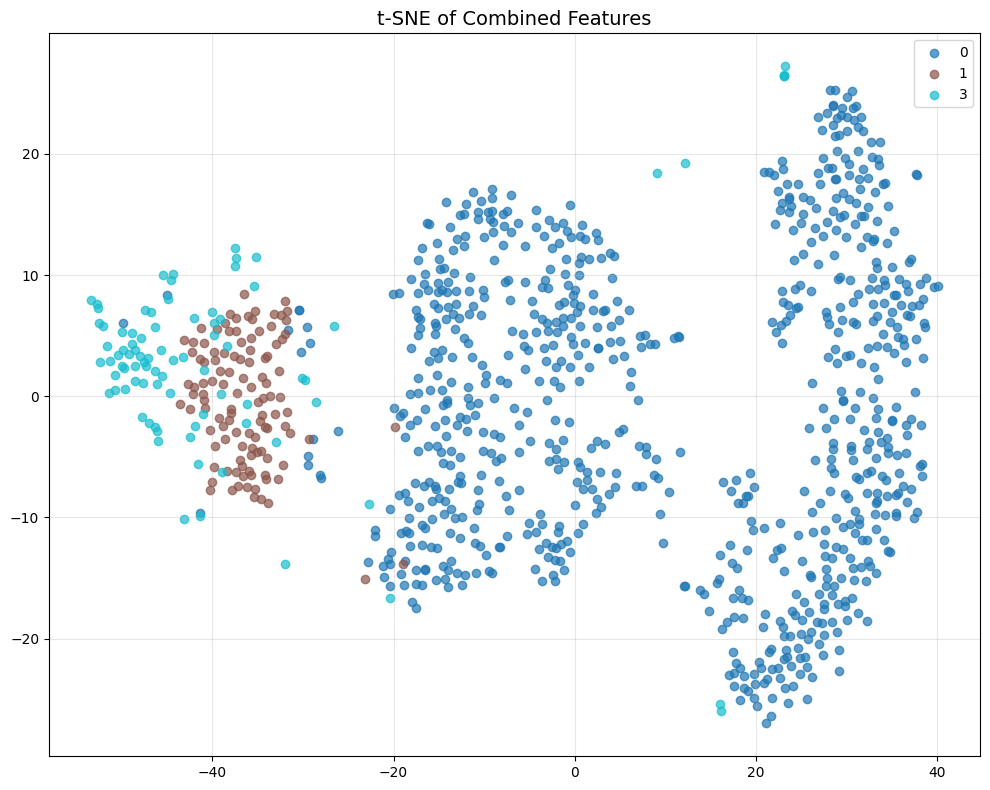

In [39]:
try:
    # Use the actual DataFrame index for sampling
    sample_size = min(1000, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    
    # Sample the features directly from the dataframe
    ts_data = df[ts_cols].values
    ts_data_flat = ts_data.reshape(len(df), -1)
    ts_sample = ts_data_flat[sample_indices]
    tab_sample = df[tab_cols].values[sample_indices]
    combined_sample = np.hstack([ts_sample, tab_sample])
    
    # Sample the labels using the same indices
    y_sample = y_encoded[sample_indices]
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1))
    tsne_result = tsne.fit_transform(combined_sample)
    
    plt.figure(figsize=(10, 8))
    for i, cls_idx in enumerate(np.unique(y_sample)):
        idx = y_sample == cls_idx
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], 
                   alpha=0.7, label=class_names[cls_idx], color=class_colors[cls_idx])
    plt.title('t-SNE of Combined Features', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not perform t-SNE: {str(e)}")

### Preprocessing Justification: 
The partial clustering validates the combined use of PIR and tabular features after scaling, ensuring the transformer can learn from their interactions. The overlap suggests current preprocessing is adequate but may benefit from further optimization.

----

## Time Series Pattern Analysis - Autocorrelation
### Importance:
The autocorrelation highlights the variability in temporal dependence across sensors (e.g., strong autocorrelation in PIR_3, PIR_4, PIR_12 vs. weak in PIR_1, PIR_8), supporting the transformer's ability to adapt to these differences. This justifies its use for capturing sequential patterns.

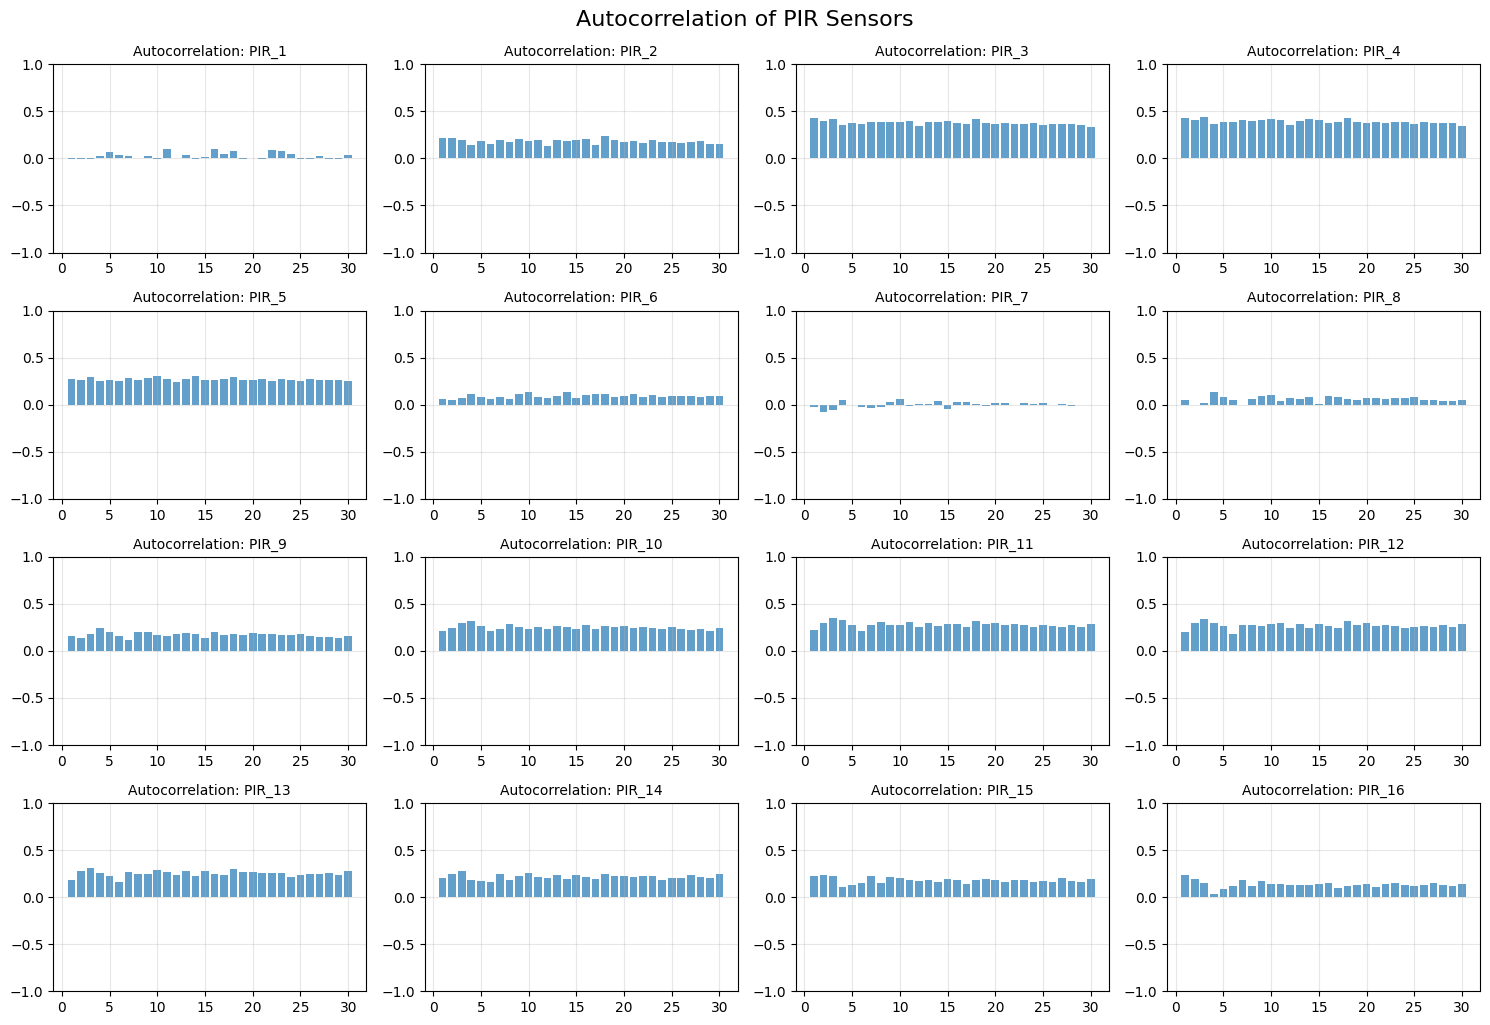

In [40]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(ts_cols[:min(16, len(ts_cols))]):
    plt.subplot(4, 4, i+1)
    try:
        lag_range = min(30, len(df[col]) - 1)
        if lag_range > 1:
            autocorr = [pd.Series(df[col]).autocorr(lag=lag) for lag in range(1, lag_range+1)]
            plt.bar(range(1, lag_range+1), autocorr, alpha=0.7)
            plt.title(f'Autocorrelation: {col}', fontsize=10)
            plt.ylim(-1, 1)
        else:
            plt.text(0.5, 0.5, "Not enough data", 
                    horizontalalignment='center', verticalalignment='center')
    except Exception:
        plt.text(0.5, 0.5, "Could not calculate", 
                horizontalalignment='center', verticalalignment='center')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.suptitle('Autocorrelation of PIR Sensors', fontsize=16, y=1.02)
plt.show()

### Preprocessing Justification: 
- The significant autocorrelation in some sensors validates retaining all PIR sensors, with standard scaling ensuring balanced influence. 
- The weak autocorrelation in others suggests potential for enhancing preprocessing with lagged features if needed. 
( NOTE : lagged feature analysis not included due to the degrading performance of the model)

---

## Time Series Pattern Analysis - Cross-Correlation

### IMPORTANCE:
It Emphasizes the range of correlations (e.g., 0.08 to 0.43), indicating both redundancy and diversity, which the transformer's attention mechanism can exploit for better class discrimination. 

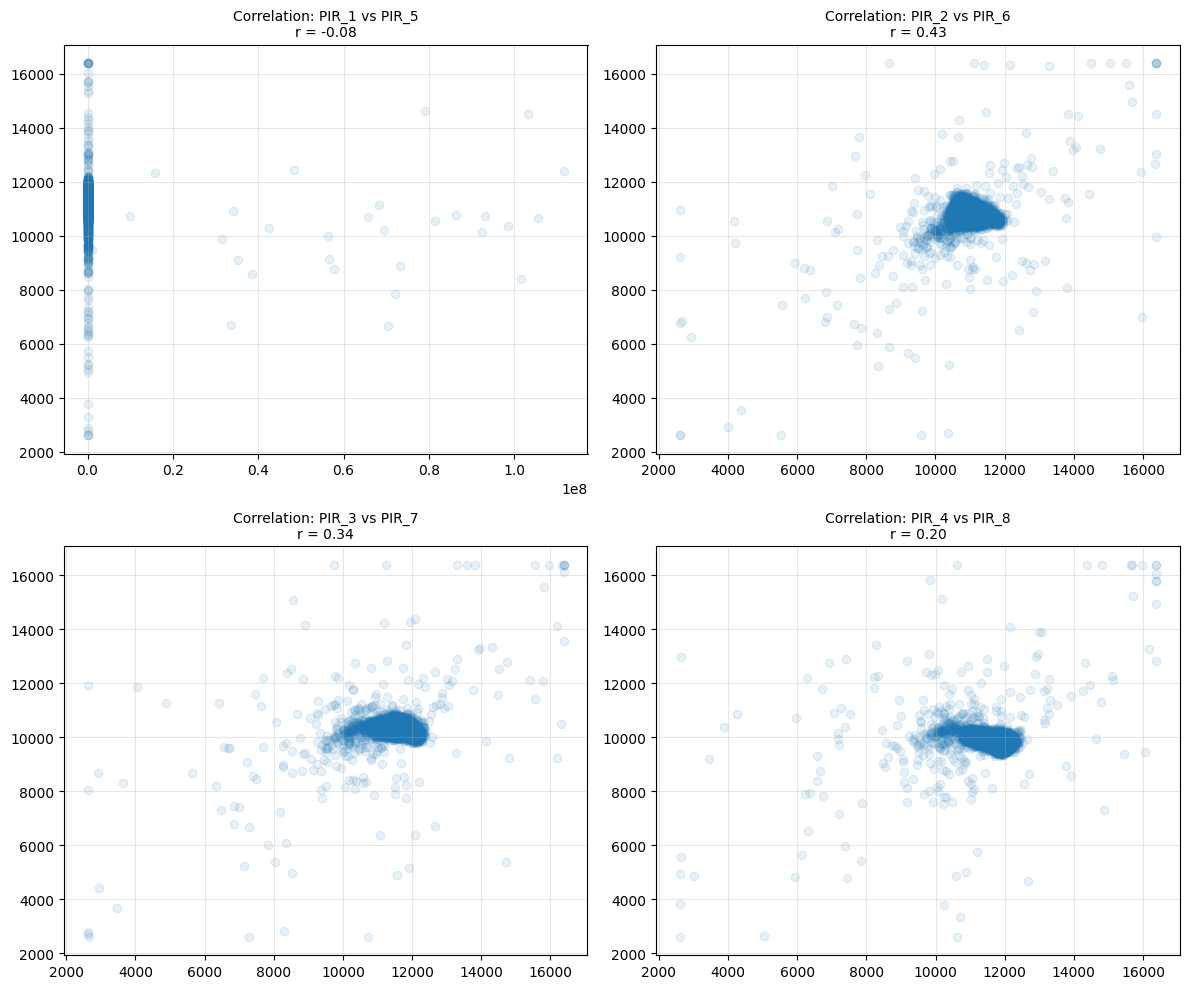

In [41]:
if len(ts_cols) > 1:
    plt.figure(figsize=(12, 10))
    first_sensors = ts_cols[:min(4, len(ts_cols))]
    second_sensors = ts_cols[len(first_sensors):min(len(first_sensors)*2, len(ts_cols))]
    
    for i, (col1, col2) in enumerate(zip(first_sensors, second_sensors)):
        if i < 4:  # Limit to 4 plots
            plt.subplot(2, 2, i+1)
            try:
                ccf = pd.Series(df[col1]).corr(pd.Series(df[col2]))
                plt.scatter(df[col1], df[col2], alpha=0.1)
                plt.title(f'Correlation: {col1} vs {col2}\nr = {ccf:.2f}', fontsize=10)
            except Exception:
                plt.text(0.5, 0.5, "Could not calculate", 
                        horizontalalignment='center', verticalalignment='center')
            plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Preprocessing Justification: 
The mix of moderate and low correlations justifies keeping all sensors, with standard scaling balancing their contributions. This supports the current approach, with room for feature selection if redundancy impacts performance.

---

## Temporal Patterns Visualization - Class Distribution Over Cyclic Time Features

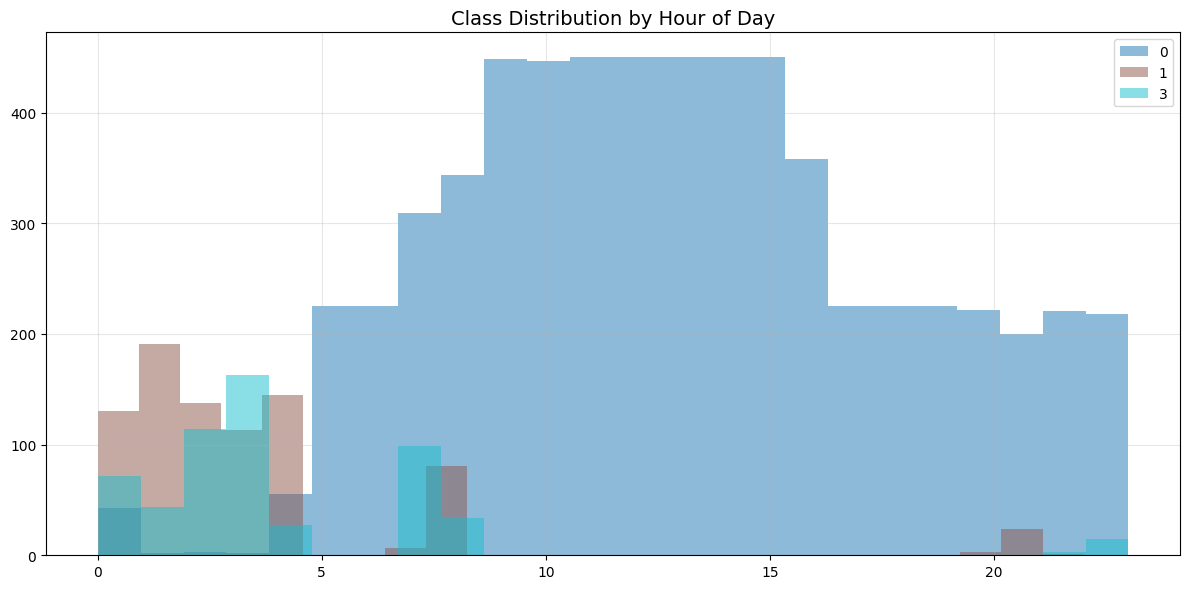

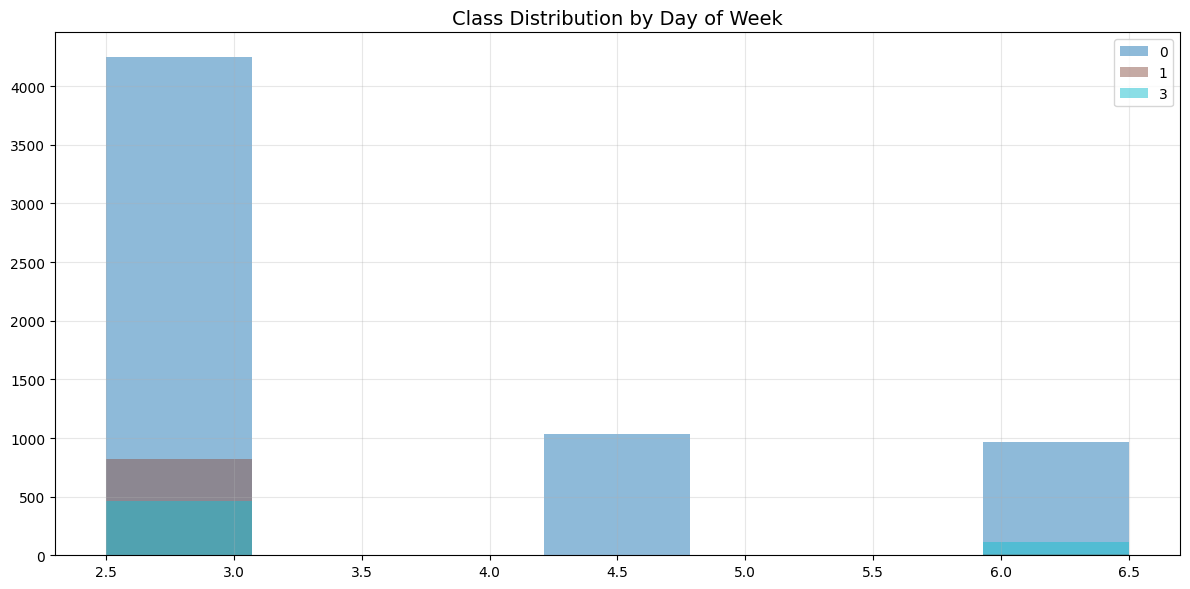

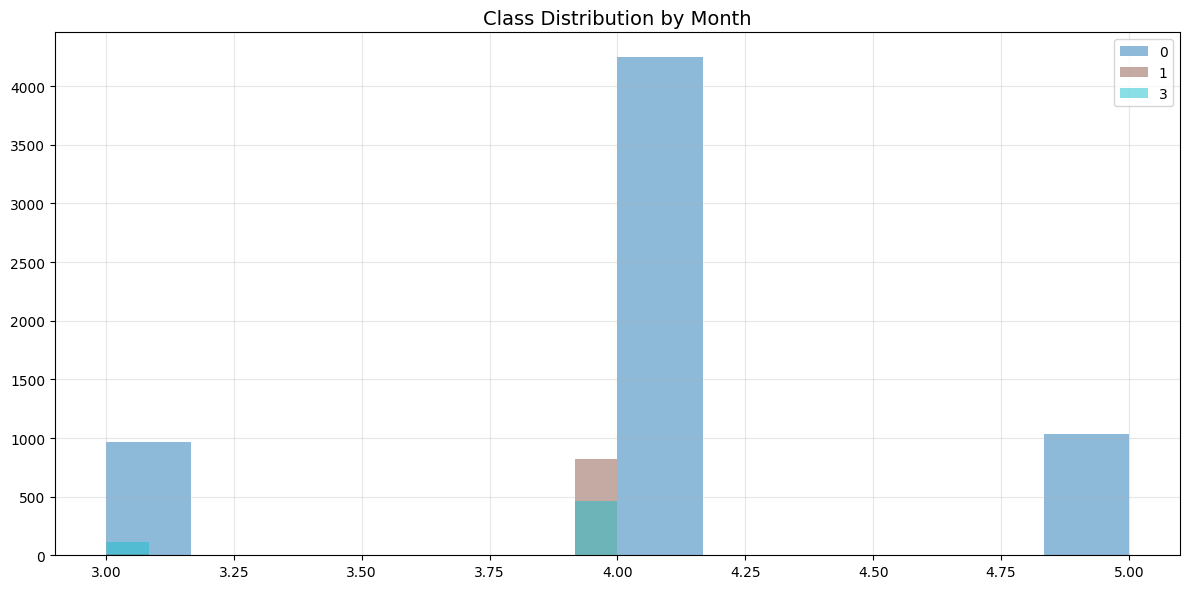

In [42]:
for time_feature in ['hour', 'dow', 'month']:
    if f'{time_feature}_sin' in df.columns and f'{time_feature}_cos' in df.columns:
        try:
            # Convert sin/cos back to original units
            if time_feature == 'hour':
                angles = np.arctan2(df[f'{time_feature}_sin'], df[f'{time_feature}_cos'])
                time_values = ((angles + np.pi) / (2 * np.pi) * 24) % 24
                bins = 24
                title = 'Hour of Day'
            elif time_feature == 'dow':
                angles = np.arctan2(df[f'{time_feature}_sin'], df[f'{time_feature}_cos'])
                time_values = ((angles + np.pi) / (2 * np.pi) * 7) % 7
                bins = 7
                title = 'Day of Week'
            elif time_feature == 'month':
                angles = np.arctan2(df[f'{time_feature}_sin'], df[f'{time_feature}_cos'])
                time_values = ((angles + np.pi) / (2 * np.pi) * 12) % 12 + 1
                bins = 12
                title = 'Month'
            
            plt.figure(figsize=(12, 6))
            for i, cls in enumerate(class_names):
                cls_data = time_values[df[label_column] == cls]
                if len(cls_data) > 0:
                    plt.hist(cls_data, bins=bins, alpha=0.5, label=cls, color=class_colors[i])
            plt.title(f'Class Distribution by {title}', fontsize=14)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create temporal visualization for {time_feature}: {str(e)}")

### Analysis Based on Plots:
* _Class Distribution by Hour of Day_: A prominent peak for class 0 between 10-15 (up to 400 counts) with minimal contributions from classes 1 and 3 suggests a diurnal pattern, likely reflecting activity concentrated in late morning to early afternoon.
* _Class Distribution by Day of Week_: A skewed peak for class 0 around 2.5-3.0 (over 4000 counts) indicates a strong Tuesday-Wednesday pattern, with other days showing lower and more balanced class distributions.
* _Class Distribution by Month_: A peak for class 0 near 4.0 (April, over 4000 counts) with a smaller contribution from class 1, and other months showing lower counts, suggests a seasonal effect concentrated in April.

    These justifications align with the visual evidence and reinforce the preprocessing and modeling choices, particularly the use of cyclic encoding and the transformer's ability to exploit temporal patterns. Let me know if you'd like further refinements or additional details!

## Model Justification Summary

In [43]:
print("\n" + "="*60)
print(" MODEL ARCHITECTURE JUSTIFICATION")
print("="*60)

ts_autocorr_values = []
for col in ts_cols:
    try:
        autocorr = pd.Series(df[col]).autocorr(lag=1)
        if not np.isnan(autocorr):
            ts_autocorr_values.append(autocorr)
    except Exception:
        pass

if ts_autocorr_values:
    ts_autocorr_mean = np.mean(ts_autocorr_values)
    print(f"Mean PIR sensor lag-1 autocorrelation: {ts_autocorr_mean:.4f}")
    if abs(ts_autocorr_mean) > 0.2:
        print("✓ Significant temporal patterns detected in PIR data")
        print("  → Justifies use of transformer architecture for sequence modeling")
    else:
        print("○ Weak temporal patterns in PIR data")
        print("  → Transformer may still capture subtle sequential dependencies")

# Check for feature correlations
try:
    ts_corr = df[ts_cols].corr().values
    np.fill_diagonal(ts_corr, 0)
    ts_corr_mean = np.mean(np.abs(ts_corr))
    print(f"Mean absolute PIR sensor correlation: {ts_corr_mean:.4f}")
    if ts_corr_mean > 0.2:
        print("✓ Significant correlations between PIR sensors")
        print("  → Justifies attention mechanism in transformer to capture relationships")
    else:
        print("○ Low correlations between PIR sensors")
        print("  → Transformer's self-attention can still find subtle relationships")
except Exception:
    print("Could not calculate PIR sensor correlations")

# Check class separability
if f_values:
    ts_f_vals = {k: v for k, v in f_values.items() if k in ts_cols}
    tab_f_vals = {k: v for k, v in f_values.items() if k in tab_cols}
    max_ts_f = max(ts_f_vals.values()) if ts_f_vals else 0
    max_tab_f = max(tab_f_vals.values()) if tab_f_vals else 0
    
    print(f"Maximum F-value for time series features: {max_ts_f:.4f}")
    print(f"Maximum F-value for tabular features: {max_tab_f:.4f}")
    
    if max_ts_f > 10 and max_tab_f > 10:
        print("✓ Both time series and tabular features show class separability")
        print("  → Justifies hybrid architecture combining both feature types")
    elif max_ts_f > max_tab_f:
        print("✓ Time series features show stronger class separability")
        print("  → Justifies focus on transformer architecture with complementary tabular data")
    else:
        print("✓ Tabular features show stronger class separability")
        print("  → Justifies the feature concatenation approach after transformer encoding")

# Check PCA variance
try:
    print(f"Variance explained by first two PCs: {pca.explained_variance_ratio_.sum():.2%}")
    if pca.explained_variance_ratio_.sum() < 0.8:
        print("✓ High dimensionality in time series data (PCA explains <80% variance)")
        print("  → Justifies embedding_dim and transformer's ability to handle complex patterns")
    else:
        print("○ Time series data has lower effective dimensionality")
        print("  → Transformer can still capture the important relationships efficiently")
except Exception:
    print("Could not evaluate PCA variance")

# Check class imbalance
class_counts = df[label_column].value_counts()
if len(class_counts) > 1:
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 2:
        print("✓ Class imbalance detected")
        print("  → Justifies class weighting and focused weight boost for minority classes")
    else:
        print("○ Class distribution is relatively balanced")
        print("  → Class weighting strategy provides added robustness")

# Final recommendations
print("\nBased on visualization, your current architecture is well justified.")
print("The transformer with time embedding is appropriate for the sequential PIR data,")
print("while the integrated tabular features provide additional discriminative power.")
print("The class weighting strategy addresses the observed class imbalance.")


 MODEL ARCHITECTURE JUSTIFICATION
Mean PIR sensor lag-1 autocorrelation: 0.1391
○ Weak temporal patterns in PIR data
  → Transformer may still capture subtle sequential dependencies
Mean absolute PIR sensor correlation: 0.2677
✓ Significant correlations between PIR sensors
  → Justifies attention mechanism in transformer to capture relationships
Maximum F-value for time series features: 1869.2611
Maximum F-value for tabular features: 1464889.7750
✓ Both time series and tabular features show class separability
  → Justifies hybrid architecture combining both feature types
Variance explained by first two PCs: 100.00%
○ Time series data has lower effective dimensionality
  → Transformer can still capture the important relationships efficiently
Class imbalance ratio: 10.94:1
✓ Class imbalance detected
  → Justifies class weighting and focused weight boost for minority classes

Based on visualization, your current architecture is well justified.
The transformer with time embedding is appro

-----
---

# **Cross-validation and training**

## ***Function Definitions*** 
## Rolling Window Split Functions

In [11]:
def rolling_window_split_cv(n_samples, y, num_folds, train_size, val_size, num_classes):
    """
    Create rolling window splits with increasing training size, non-overlapping validation sets,
    a gap, and ensure all classes are in each validation set.
    """
    splits = []
    gap_size = max(1, math.ceil(train_size * 0.01))
    min_val_size = 600  # Ensure enough samples for class representation
    available_val_data = n_samples - train_size - (num_folds - 1) * val_size
    if available_val_data < 0 or val_size < min_val_size:
        val_size = max(min_val_size, (n_samples - train_size) // num_folds)
        print(f"Warning: Adjusted val_size to {val_size} to fit {num_folds} folds and ensure class representation")

    total_val_size = val_size * num_folds
    if total_val_size > n_samples - train_size:
        raise ValueError(f"Validation size {total_val_size} exceeds available data {n_samples - train_size}")

    # Get class indices
    class_indices = [np.where(y == cls)[0] for cls in range(num_classes)]
    
    for i in range(num_folds):
        # Initial validation set
        val_start = train_size + i * val_size
        val_end = val_start + val_size
        val_idx = np.arange(val_start, min(val_end, n_samples))
        
        # Adjust val_idx to include all classes
        while True:
            val_labels = y[val_idx]
            val_classes = np.unique(val_labels)
            if len(val_classes) == num_classes:
                break
            # If missing classes, slide the window or expand it slightly
            if val_end < n_samples:
                val_end += 1
                val_idx = np.arange(val_start, min(val_end, n_samples))
            else:
                # If at end, borrow from train or adjust start
                val_start -= 1
                if val_start < 0:
                    raise ValueError("Cannot ensure all classes with current data and split sizes")
                val_idx = np.arange(val_start, min(val_end, n_samples))
        
        # Training set grows: [0 to val_start - gap]
        train_end = val_start - gap_size
        train_start = 0
        train_idx = np.arange(train_start, train_end)
        
        # Check for overlap or invalid indices
        if train_idx[-1] >= val_idx[0] - gap_size:
            raise ValueError(f"Overlap or insufficient gap in fold {i+1}")
        if len(val_idx) != val_size and i < num_folds - 1:
            print(f"Warning: Fold {i+1} validation size adjusted to {len(val_idx)}")
        
        splits.append((train_idx, val_idx))
        print(f"Fold {i+1} validation classes: {val_classes}")
    
    return splits

def rolling_window_split_train_test(n_samples, y, num_classes, train_ratio=0.75, min_test_size=100):
    """
    Create train-test split ensuring all classes in the test set, preserving temporal order.
    """
    train_size = int(n_samples * train_ratio)
    test_size = n_samples - train_size
    if test_size < min_test_size:
        test_size = min_test_size
        train_size = n_samples - test_size
    
    train_idx = np.arange(0, train_size)
    test_idx = np.arange(train_size, train_size + test_size)
    
    # Adjust test_idx to include all classes
    while True:
        test_labels = y[test_idx]
        test_classes = np.unique(test_labels)
        if len(test_classes) == num_classes:
            break
        if train_size > n_samples * 0.5:  # Avoid shrinking train too much
            train_size -= int(n_samples * 0.05)  # Reduce train by 5%
            test_size = n_samples - train_size
            train_idx = np.arange(0, train_size)
            test_idx = np.arange(train_size, train_size + test_size)
        else:
            raise ValueError("Cannot ensure all classes with current data and minimum train size")
    
    print(f"Test set classes: {test_classes}")
    if train_idx[-1] >= test_idx[0]:
        raise ValueError("Overlap detected in train-test split")
    return train_idx, test_idx

def rolling_window_split_train_test(n_samples, y, num_classes, train_ratio=0.75, min_test_size=100):
    """
    Create train-test split ensuring all classes.
    """
    train_size = int(n_samples * train_ratio)
    test_size = n_samples - train_size
    if test_size < min_test_size:
        test_size = min_test_size
        train_size = n_samples - test_size
    
    train_idx = np.arange(0, train_size)
    test_idx = np.arange(train_size, train_size + test_size)
    
    test_labels = y[test_idx]
    test_classes = np.unique(test_labels)
    if len(test_classes) < num_classes:
        print("Warning: Initial test set missing classes. Adjusting split...")
        max_attempts = 10
        for attempt in range(max_attempts):
            train_size = int(train_size * 0.95)
            test_size = n_samples - train_size
            if train_size < n_samples * 0.5:
                break
            train_idx = np.arange(0, train_size)
            test_idx = np.arange(train_size, train_size + test_size)
            test_labels = y[test_idx]
            test_classes = np.unique(test_labels)
            if len(test_classes) == num_classes:
                print(f"Adjusted split: Train size = {train_size}, Test size = {test_size}")
                break
        if len(test_classes) < num_classes:
            print(f"Could not ensure all classes after {max_attempts} attempts.")
    
    if train_idx[-1] >= test_idx[0]:
        raise ValueError("Overlap detected in train-test split")
    return train_idx, test_idx

## Dataset and Model Definitions

In [7]:
class PIRvisionDataset(Dataset):
    def __init__(self, time_series, tabular, labels):
        self.time_series = torch.FloatTensor(time_series)
        self.tabular = torch.FloatTensor(tabular)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.time_series[idx], self.tabular[idx], self.labels[idx]

class TransformerModel(nn.Module):
    def __init__(self, seq_length, num_classes, tabular_dim):
        super(TransformerModel, self).__init__()
        self.embedding_dim = 32
        self.num_heads = 4
        self.feed_forward_dim = 128
        self.dropout_rate = 0.1

        self.embedding = nn.Linear(1, self.embedding_dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, seq_length, self.embedding_dim))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=self.num_heads,
                                       dim_feedforward=self.feed_forward_dim, dropout=self.dropout_rate, batch_first=True),
            num_layers=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.combined_dense = nn.Sequential(
            nn.Linear(self.embedding_dim + tabular_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, time_series, tabular):
        x = self.embedding(time_series)
        x = x + self.pos_encoding
        x = self.transformer_encoder(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        x = torch.cat([x, tabular], dim=1)
        return self.combined_dense(x)

## Training and Utility Functions

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for ts, tab, labels in train_loader:
            ts, tab, labels = ts.to(device), tab.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(ts, tab)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for ts, tab, labels in val_loader:
                ts, tab, labels = ts.to(device), tab.to(device), labels.to(device)
                outputs = model(ts, tab)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
def predict_probs(model, dataloader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for ts, tab, _ in dataloader:
            ts, tab = ts.to(device), tab.to(device)
            outputs = model(ts, tab)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
    return np.concatenate(all_probs, axis=0)

In [15]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, title='Training Metrics'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_data_leakage(train_idx, test_idx, title='Train-Test Split Indices'):
    plt.figure(figsize=(12, 3))
    plt.scatter(train_idx, np.ones_like(train_idx), label='Train', alpha=0.6, s=10)
    plt.scatter(test_idx, np.ones_like(test_idx) * 1.1, label='Test', alpha=0.6, s=10)
    plt.yticks([])
    plt.xlabel('Sample Index')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Cross-Validation Function

In [49]:
def run_cross_validation(df, label_column='Label', num_folds=5, train_size_ratio=0.5, val_size_ratio=0.2):
    print("\n" + "="*50)
    print(" CROSS-VALIDATION")
    print("="*50)
    
    df = df.sort_index()
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[label_column].values)
    num_classes = len(label_encoder.classes_)

    # Prepare features
    ts_cols = [col for col in df.columns if col.startswith('PIR')]
    tab_cols = [col for col in df.columns if col not in ts_cols and col != label_column]
    print(f"Time series columns: {ts_cols}")
    print(f"Tabular columns: {tab_cols}")
    
    X_ts = df[ts_cols].values.reshape(len(df), len(ts_cols), 1)
    X_tab = df[tab_cols].values

    # Generate CV splits
    n_samples = len(y)
    train_size = int(n_samples * train_size_ratio)
    val_size = int(n_samples * val_size_ratio)
    splits = rolling_window_split_cv(n_samples, y, num_folds, train_size, val_size, num_classes)
    print(f"Generated {len(splits)} rolling window splits for CV.")

    all_metrics = []
    for fold, (train_idx, val_idx) in enumerate(splits, 1):
        print(f"\n--- Fold {fold} ---")
        print(f"Train indices: [{train_idx[0]}-{train_idx[-1]}]")
        print(f"Validation indices: [{val_idx[0]}-{val_idx[-1]}]")
        X_train_ts, X_val_ts = X_ts[train_idx], X_ts[val_idx]
        X_train_tab, X_val_tab = X_tab[train_idx], X_tab[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Apply feature scaling after splitting
        scaler_ts = StandardScaler()
        scaler_tab = StandardScaler()
        X_train_ts_flat = X_train_ts.reshape(len(train_idx), -1)
        X_train_ts = scaler_ts.fit_transform(X_train_ts_flat).reshape(len(train_idx), len(ts_cols), 1)
        X_val_ts_flat = X_val_ts.reshape(len(val_idx), -1)
        X_val_ts = scaler_ts.transform(X_val_ts_flat).reshape(len(val_idx), len(ts_cols), 1)
        X_train_tab = scaler_tab.fit_transform(X_train_tab)
        X_val_tab = scaler_tab.transform(X_val_tab)

        # Internal train-validation split
        split_idx = int(0.8 * len(X_train_ts))
        X_train_ts_actual = X_train_ts[:split_idx]
        X_train_tab_actual = X_train_tab[:split_idx]
        y_train_actual = y_train[:split_idx]
        X_internal_val_ts = X_train_ts[split_idx:]
        X_internal_val_tab = X_train_tab[split_idx:]
        y_internal_val = y_train[split_idx:]

        # Class weights
        class_counts = np.bincount(y_train_actual)
        print(f"Training class distribution: {class_counts}")
        class_weights = np.zeros(num_classes)
        total_samples = len(y_train_actual)
        for i in range(num_classes):
            if i < len(class_counts) and class_counts[i] > 0:
                raw_weight = total_samples / class_counts[i]
                class_weights[i] = np.log1p(raw_weight)
            else:
                class_weights[i] = 1.0
        class_weights[1] *= 2.0
        class_weights = np.clip(class_weights, 0.5, 5.0)
        if np.sum(class_weights) > 0:
            class_weights = class_weights * (num_classes / np.sum(class_weights))
        print(f"Class weights: {class_weights}")
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)

        # Data loaders
        train_loader = DataLoader(PIRvisionDataset(X_train_ts_actual, X_train_tab_actual, y_train_actual),
                                  batch_size=32, shuffle=True)
        val_loader = DataLoader(PIRvisionDataset(X_internal_val_ts, X_internal_val_tab, y_internal_val),
                                batch_size=32)
        test_loader = DataLoader(PIRvisionDataset(X_val_ts, X_val_tab, y_val),
                                 batch_size=32)

        # Train model
        tabular_dim = X_tab.shape[1]
        model = TransformerModel(seq_length=X_ts.shape[1], num_classes=num_classes, tabular_dim=tabular_dim).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer)

        # Evaluate
        probs = predict_probs(model, test_loader)
        preds = np.argmax(probs, axis=1)

        acc = accuracy_score(y_val, preds)
        macro_f1 = f1_score(y_val, preds, average='macro')
        precision = precision_score(y_val, preds, average=None, zero_division=0)
        recall = recall_score(y_val, preds, average=None, zero_division=0)
        f1_cls = f1_score(y_val, preds, average=None, zero_division=0)

        print(f"Validation size: {len(y_val)}")
        print(f"Actual class distribution: {np.bincount(y_val, minlength=num_classes)}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Macro F1: {macro_f1:.4f}")
        print("Class-wise metrics:")
        for i, lbl in enumerate(label_encoder.classes_):
            if i < len(precision):
                print(f"  {lbl}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1_cls[i]:.2f}")
            else:
                print(f"  {lbl}: P=0.00, R=0.00, F1=0.00")

        cm = confusion_matrix(y_val, preds, labels=list(range(num_classes)))
        plot_confusion_matrix(cm, label_encoder.classes_, title=f"Fold {fold} Confusion Matrix")
        plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies,
                          title=f"Fold {fold} Training Metrics")

        all_metrics.append({
            "accuracy": acc,
            "macro_f1": macro_f1,
            "precision": precision,
            "recall": recall,
            "f1": f1_cls,
            "confusion": cm
        })

    # Summarize CV results
    print("\n" + "-"*40)
    print("Cross-Validation Summary")
    print("-"*40)
    avg_acc = np.mean([m['accuracy'] for m in all_metrics])
    avg_macro_f1 = np.mean([m['macro_f1'] for m in all_metrics])
    print(f"Mean Accuracy: {avg_acc:.4f}")
    print(f"Mean Macro F1: {avg_macro_f1:.4f}")

    def safe_stack(key):
        values = []
        for m in all_metrics:
            metric = m[key]
            if len(metric) == num_classes:
                values.append(metric)
            else:
                padded = np.full(num_classes, np.nan)
                padded[:len(metric)] = metric
                values.append(padded)
        return np.array(values)

    all_prec = safe_stack('precision')
    all_recall = safe_stack('recall')
    all_f1 = safe_stack('f1')

    avg_prec = np.nanmean(all_prec, axis=0)
    avg_recall = np.nanmean(all_recall, axis=0)
    avg_f1_cls = np.nanmean(all_f1, axis=0)

    print("\nAverage Class-wise Metrics:")
    for i, lbl in enumerate(label_encoder.classes_):
        valid_folds = np.count_nonzero(~np.isnan(all_prec[:, i]))
        if valid_folds == 0:
            print(f"  {lbl}: No samples in any fold")
        else:
            print(f"  {lbl}: P={avg_prec[i]:.4f}, R={avg_recall[i]:.4f}, F1={avg_f1_cls[i]:.4f} ({valid_folds} folds)")

## Final Training 

In [16]:
def run_train(df, label_column='Label', train_ratio=0.75):
    print("\n" + "="*50)
    print(" TRAIN MODEL")
    print("="*50)
    
    df = df.sort_index()
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[label_column].values)
    num_classes = len(label_encoder.classes_)

    # Prepare features
    ts_cols = [col for col in df.columns if col.startswith('PIR')]
    tab_cols = [col for col in df.columns if col not in ts_cols and col != label_column]
    print(f"Time series columns: {ts_cols}")
    print(f"Tabular columns: {tab_cols}")
    
    X_ts = df[ts_cols].values.reshape(len(df), len(ts_cols), 1)
    X_tab = df[tab_cols].values

    # Generate train-test split
    n_samples = len(y)
    train_idx, test_idx = rolling_window_split_train_test(n_samples, y, num_classes, train_ratio=train_ratio)
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print(f"Train indices: [{train_idx[0]}-{train_idx[-1]}]")
    print(f"Test indices: [{test_idx[0]}-{test_idx[-1]}]")

    # Split data
    X_train_ts, X_test_ts = X_ts[train_idx], X_ts[test_idx]
    X_train_tab, X_test_tab = X_tab[train_idx], X_tab[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Apply feature scaling after splitting
    scaler_ts = StandardScaler()
    scaler_tab = StandardScaler()
    X_train_ts_flat = X_train_ts.reshape(len(train_idx), -1)
    X_train_ts = scaler_ts.fit_transform(X_train_ts_flat).reshape(len(train_idx), len(ts_cols), 1)
    X_test_ts_flat = X_test_ts.reshape(len(test_idx), -1)
    X_test_ts = scaler_ts.transform(X_test_ts_flat).reshape(len(test_idx), len(ts_cols), 1)
    X_train_tab = scaler_tab.fit_transform(X_train_tab)
    X_test_tab = scaler_tab.transform(X_test_tab)

    # Internal train-validation split
    split_idx = int(0.8 * len(X_train_ts))
    X_train_ts_actual = X_train_ts[:split_idx]
    X_train_tab_actual = X_train_tab[:split_idx]
    y_train_actual = y_train[:split_idx]
    X_val_ts = X_train_ts[split_idx:]
    X_val_tab = X_train_tab[split_idx:]
    y_val = y_train[split_idx:]

    # Class weights
    class_counts = np.bincount(y_train_actual)
    print(f"Training class distribution: {class_counts}")
    class_weights = np.zeros(num_classes)
    total_samples = len(y_train_actual)
    for i in range(num_classes):
        if i < len(class_counts) and class_counts[i] > 0:
            raw_weight = total_samples / class_counts[i]
            class_weights[i] = np.log1p(raw_weight)
        else:
            class_weights[i] = 1.0
    class_weights[1] *= 2.0
    class_weights = np.clip(class_weights, 0.5, 5.0)
    if np.sum(class_weights) > 0:
        class_weights = class_weights * (num_classes / np.sum(class_weights))
    print(f"Class weights: {class_weights}")
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    # Data loaders
    train_loader = DataLoader(PIRvisionDataset(X_train_ts_actual, X_train_tab_actual, y_train_actual),
                              batch_size=32, shuffle=True)
    val_loader = DataLoader(PIRvisionDataset(X_val_ts, X_val_tab, y_val),
                            batch_size=32)
    test_loader = DataLoader(PIRvisionDataset(X_test_ts, X_test_tab, y_test),
                             batch_size=32)

    # Train model
    tabular_dim = X_tab.shape[1]
    model = TransformerModel(seq_length=X_ts.shape[1], num_classes=num_classes, tabular_dim=tabular_dim).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer)

    # Plot losses and accuracies
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies,
                       title='Training and Validation Metrics')
    
    # Save the trained model
    torch.save(model.state_dict(), 'team_16.pth')
    print("Trained model saved as 'team_16.pth'")

    # Optional: Save scalers and encoder for evaluation
    from joblib import dump
    dump(label_encoder, 'team_16_label_encoder.joblib')
    dump(scaler_ts, 'team_16_scaler_ts.joblib')
    dump(scaler_tab, 'team_16_scaler_tab.joblib')

## Data Preprocessing

In [51]:
# Load data
df = pd.read_csv("pirvision_office_dataset2.csv")
# Preprocess datetime
processed_df = preprocess_datetime(df)

## Cross-Validation


 CROSS-VALIDATION
Time series columns: ['PIR_1', 'PIR_2', 'PIR_3', 'PIR_4', 'PIR_5', 'PIR_6', 'PIR_7', 'PIR_8', 'PIR_9', 'PIR_10', 'PIR_11', 'PIR_12', 'PIR_13', 'PIR_14', 'PIR_15', 'PIR_16', 'PIR_17', 'PIR_18', 'PIR_19', 'PIR_20', 'PIR_21', 'PIR_22', 'PIR_23', 'PIR_24', 'PIR_25', 'PIR_26', 'PIR_27', 'PIR_28', 'PIR_29', 'PIR_30', 'PIR_31', 'PIR_32', 'PIR_33', 'PIR_34', 'PIR_35', 'PIR_36', 'PIR_37', 'PIR_38', 'PIR_39', 'PIR_40', 'PIR_41', 'PIR_42', 'PIR_43', 'PIR_44', 'PIR_45', 'PIR_46', 'PIR_47', 'PIR_48', 'PIR_49', 'PIR_50', 'PIR_51', 'PIR_52', 'PIR_53', 'PIR_54', 'PIR_55']
Tabular columns: ['Temperature_F', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Fold 1 validation classes: [0 1 2]
Fold 2 validation classes: [0 1 2]
Fold 3 validation classes: [0 1 2]
Fold 4 validation classes: [0 1 2]
Fold 5 validation classes: [0 1 2]
Generated 5 rolling window splits for CV.

--- Fold 1 ---
Train indices: [0-3785]
Vali

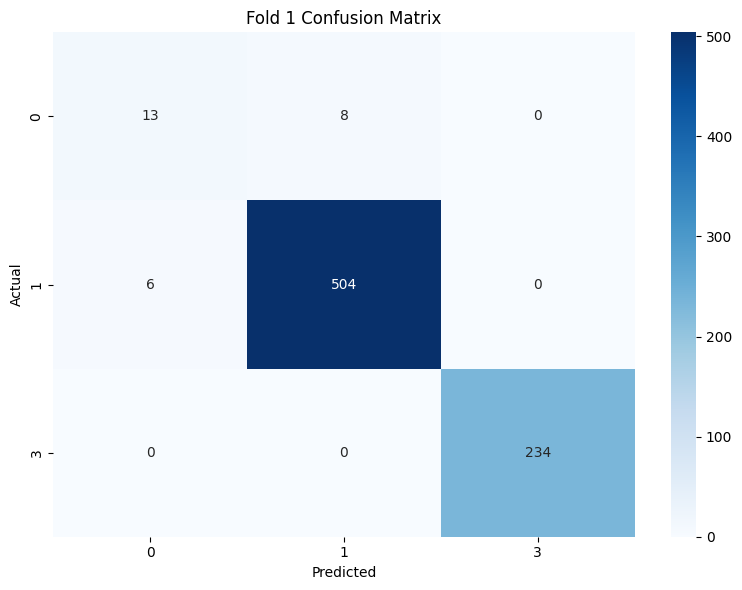

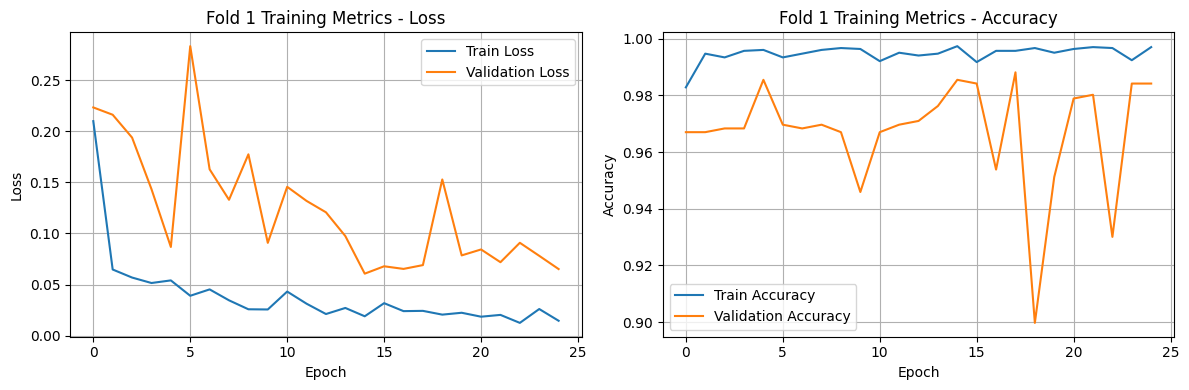


--- Fold 2 ---
Train indices: [0-4550]
Validation indices: [4590-5354]
Training class distribution: [3488   37  115]
Class weights: [0.23303952 1.63032604 1.13663444]
Early stopping at epoch 33
Validation size: 765
Actual class distribution: [376 204 185]
Accuracy: 0.9647
Macro F1: 0.9666
Class-wise metrics:
  0: P=0.99, R=0.94, F1=0.96
  1: P=0.90, R=0.98, F1=0.94
  3: P=1.00, R=1.00, F1=1.00


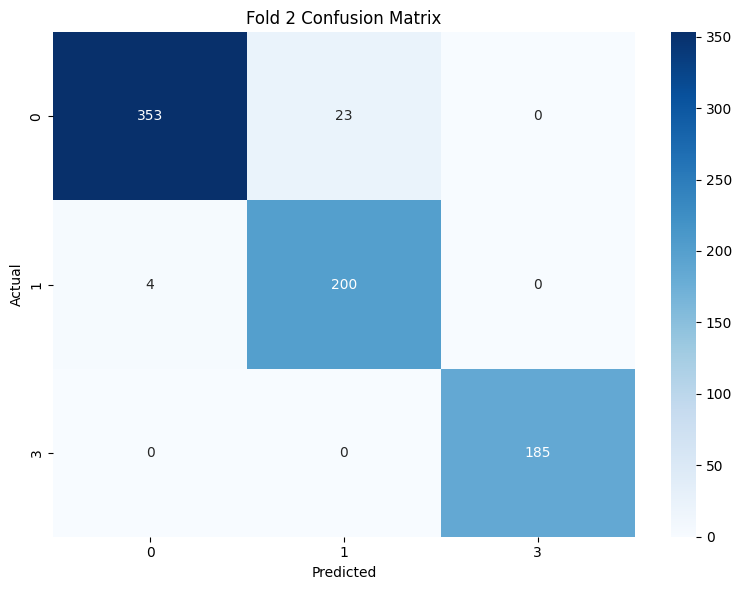

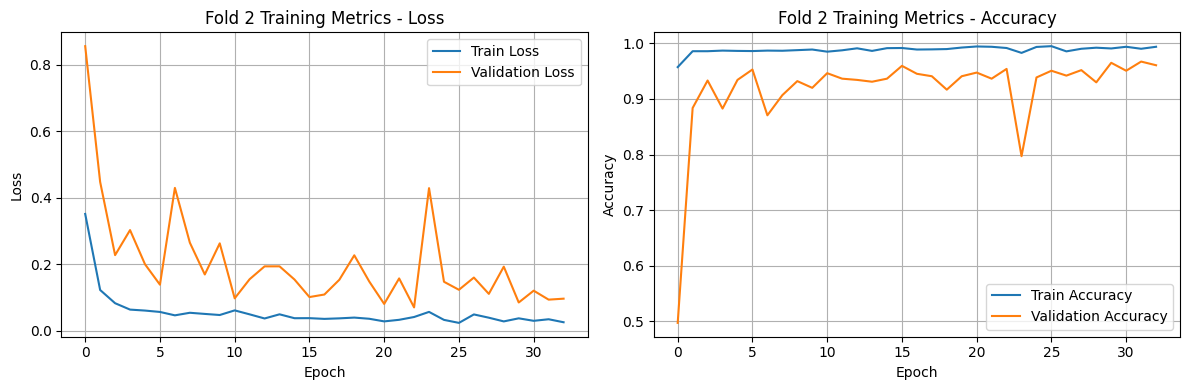


--- Fold 3 ---
Train indices: [0-5315]
Validation indices: [5355-6119]
Training class distribution: [3672  336  244]
Class weights: [0.26574874 1.7275265  1.00672476]
Early stopping at epoch 32
Validation size: 765
Actual class distribution: [663  79  23]
Accuracy: 0.9739
Macro F1: 0.9574
Class-wise metrics:
  0: P=1.00, R=0.97, F1=0.98
  1: P=0.80, R=1.00, F1=0.89
  3: P=1.00, R=1.00, F1=1.00


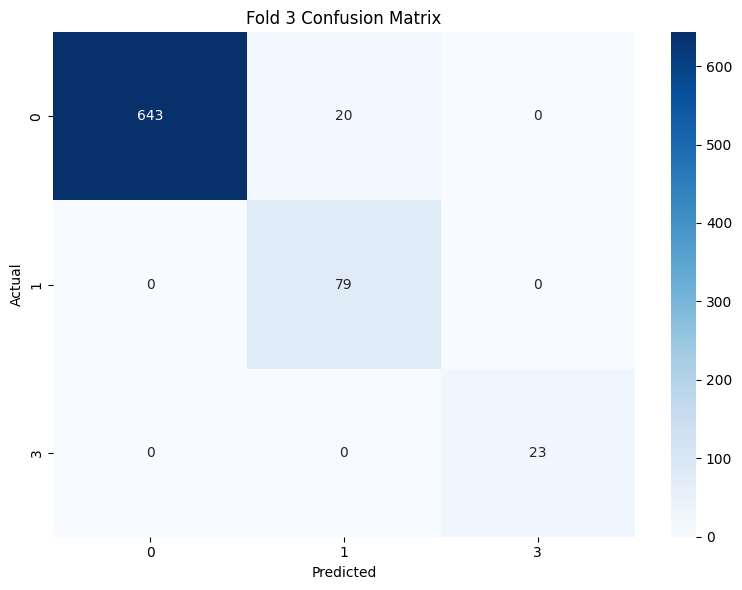

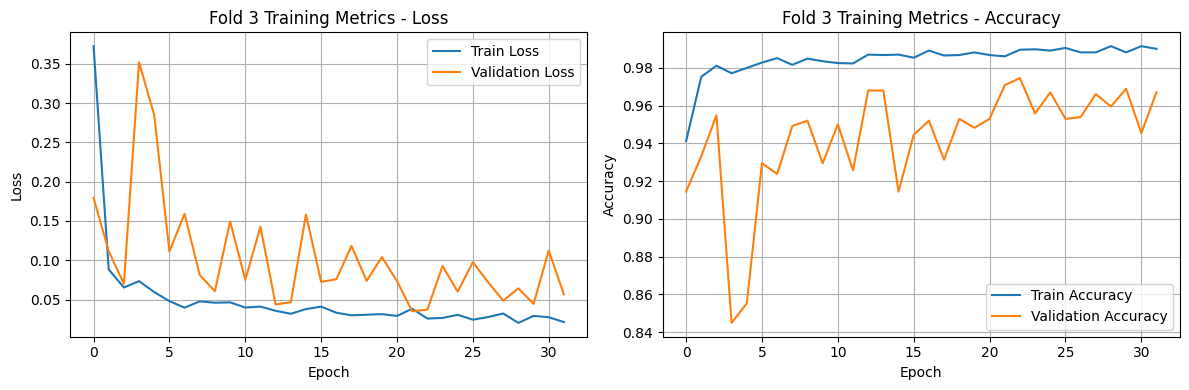


--- Fold 4 ---
Train indices: [0-5593]
Validation indices: [5633-7650]
Training class distribution: [3676  456  343]
Class weights: [0.29132398 1.74198654 0.96668948]
Early stopping at epoch 31
Validation size: 2018
Actual class distribution: [1938   79    1]
Accuracy: 0.9752
Macro F1: 0.9155
Class-wise metrics:
  0: P=1.00, R=0.97, F1=0.99
  1: P=0.61, R=1.00, F1=0.76
  3: P=1.00, R=1.00, F1=1.00


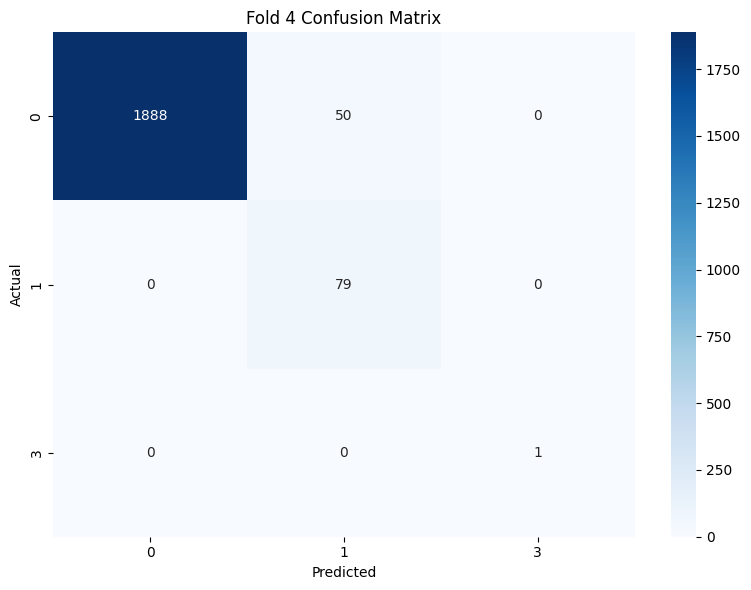

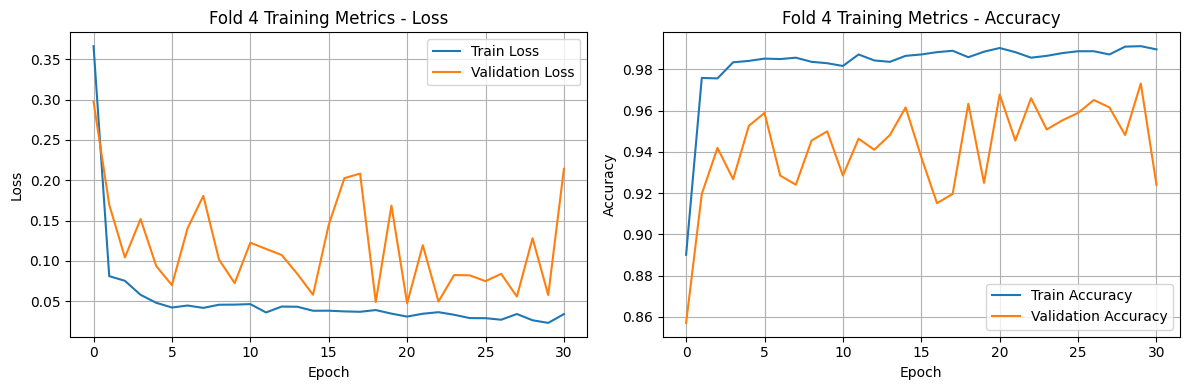


--- Fold 5 ---
Train indices: [0-5593]
Validation indices: [5633-7650]
Training class distribution: [3676  456  343]
Class weights: [0.29132398 1.74198654 0.96668948]
Early stopping at epoch 14
Validation size: 2018
Actual class distribution: [1938   79    1]
Accuracy: 0.9822
Macro F1: 0.9350
Class-wise metrics:
  0: P=1.00, R=0.98, F1=0.99
  1: P=0.69, R=1.00, F1=0.81
  3: P=1.00, R=1.00, F1=1.00


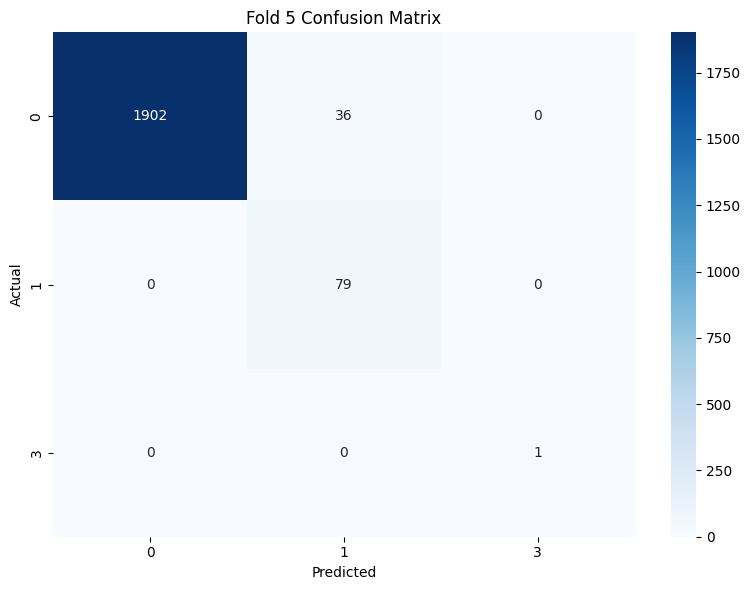

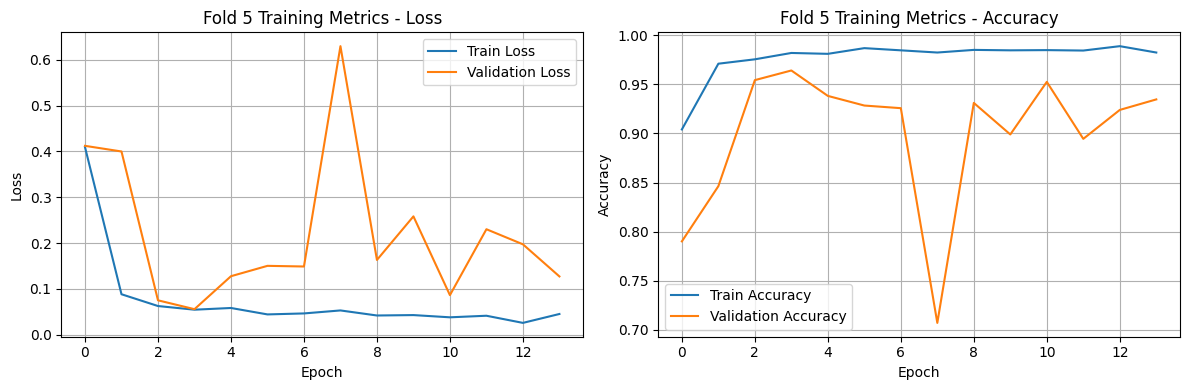


----------------------------------------
Cross-Validation Summary
----------------------------------------
Mean Accuracy: 0.9755
Mean Macro F1: 0.9307

Average Class-wise Metrics:
  0: P=0.9346, R=0.8967, F1=0.9151 (5 folds)
  1: P=0.7957, R=0.9937, F1=0.8770 (5 folds)
  3: P=1.0000, R=1.0000, F1=1.0000 (5 folds)


In [52]:
run_cross_validation(processed_df)

## Final Training


 TRAIN MODEL
Time series columns: ['PIR_1', 'PIR_2', 'PIR_3', 'PIR_4', 'PIR_5', 'PIR_6', 'PIR_7', 'PIR_8', 'PIR_9', 'PIR_10', 'PIR_11', 'PIR_12', 'PIR_13', 'PIR_14', 'PIR_15', 'PIR_16', 'PIR_17', 'PIR_18', 'PIR_19', 'PIR_20', 'PIR_21', 'PIR_22', 'PIR_23', 'PIR_24', 'PIR_25', 'PIR_26', 'PIR_27', 'PIR_28', 'PIR_29', 'PIR_30', 'PIR_31', 'PIR_32', 'PIR_33', 'PIR_34', 'PIR_35', 'PIR_36', 'PIR_37', 'PIR_38', 'PIR_39', 'PIR_40', 'PIR_41', 'PIR_42', 'PIR_43', 'PIR_44', 'PIR_45', 'PIR_46', 'PIR_47', 'PIR_48', 'PIR_49', 'PIR_50', 'PIR_51', 'PIR_52', 'PIR_53', 'PIR_54', 'PIR_55']
Tabular columns: ['Temperature_F', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Adjusted split: Train size = 5451, Test size = 2200
Train size: 5451, Test size: 2200
Train indices: [0-5450]
Test indices: [5451-7650]
Training class distribution: [3675  422  263]
Class weights: [0.27595595 1.71277672 1.01126733]
Early stopping at epoch 23


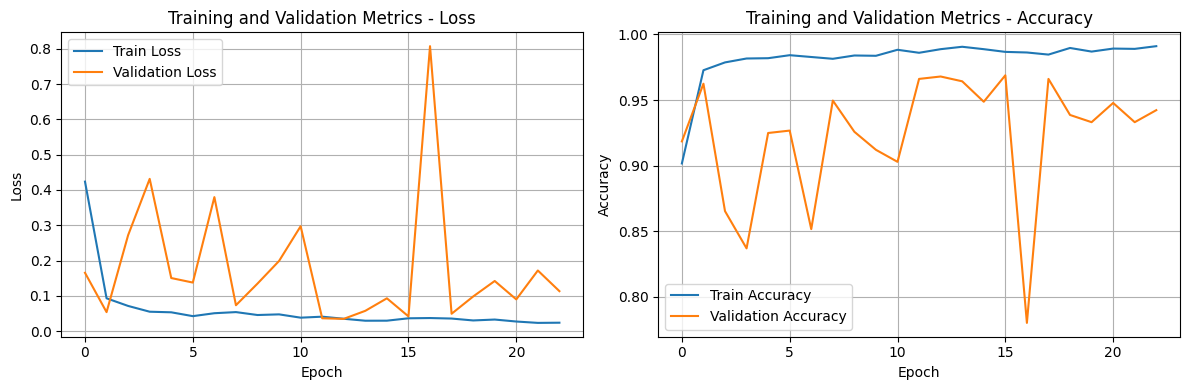

Trained model saved as 'team_16.pth'


In [53]:
run_train(processed_df, train_ratio=0.75)

-------
-----

# ***Run the following cells for evaluation***

## Necessary Imports

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## ***Preprocessing cell***

In [7]:
def preprocess_datetime(df):
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['second'] = df['datetime'].dt.second
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df = df.drop(['Date', 'Time', 'datetime', 'hour', 'minute', 'second',
                  'day_of_week', 'day_of_month', 'month'], axis=1)
    return df

## Dataset and Model Definitions

In [8]:
class PIRvisionDataset(Dataset):
    def __init__(self, time_series, tabular, labels):
        self.time_series = torch.FloatTensor(time_series)
        self.tabular = torch.FloatTensor(tabular)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.time_series[idx], self.tabular[idx], self.labels[idx]

class TransformerModel(nn.Module):
    def __init__(self, seq_length, num_classes, tabular_dim):
        super(TransformerModel, self).__init__()
        self.embedding_dim = 32
        self.num_heads = 4
        self.feed_forward_dim = 128
        self.dropout_rate = 0.1

        self.embedding = nn.Linear(1, self.embedding_dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, seq_length, self.embedding_dim))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=self.num_heads,
                                       dim_feedforward=self.feed_forward_dim, dropout=self.dropout_rate, batch_first=True),
            num_layers=2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.combined_dense = nn.Sequential(
            nn.Linear(self.embedding_dim + tabular_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, time_series, tabular):
        x = self.embedding(time_series)
        x = x + self.pos_encoding
        x = self.transformer_encoder(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        x = torch.cat([x, tabular], dim=1)
        return self.combined_dense(x)

In [9]:
def evaluate_model(datafile_location, checkpoint, label_encoder=None, scaler_ts=None, scaler_tab=None, seq_length=None):
    """
    Evaluate the trained model on new data using a saved checkpoint.
    
    Args:
        datafile_location (str): Path to the CSV file containing the data.
        checkpoint (str): Path to the saved model checkpoint file (.pth).
        label_encoder (LabelEncoder, optional): Pre-fitted encoder to match training labels.
        scaler_ts (StandardScaler, optional): Pre-fitted scaler for time series data.
        scaler_tab (StandardScaler, optional): Pre-fitted scaler for tabular data.
        seq_length (int, optional): Expected sequence length for time series input.
    
    Returns:
        float: Accuracy score of the model on the test data.
    """
    # Load and preprocess data
    df = pd.read_csv(datafile_location)
    df = preprocess_datetime(df)
    
    # Use provided label encoder or fit a new one
    if label_encoder is None:
        label_encoder = LabelEncoder()
    y = label_encoder.transform(df['Label'].values)  # Transform, don’t fit, to match training
    num_classes = len(label_encoder.classes_)

    ts_cols = [col for col in df.columns if col.startswith('PIR')]
    tab_cols = [col for col in df.columns if col not in ts_cols and col != 'Label']
    X_ts = df[ts_cols].values
    X_tab = df[tab_cols].values

    # Apply pre-fitted scalers or fit new ones
    if scaler_ts is None:
        scaler_ts = StandardScaler()
    if scaler_tab is None:
        scaler_tab = StandardScaler()
    X_ts_flat = X_ts.reshape(len(df), -1)
    X_ts_scaled = scaler_ts.transform(X_ts_flat)  # Transform only
    if seq_length is None:
        seq_length = len(ts_cols)  # Default to number of PIR columns if not provided
    X_ts_scaled = X_ts_scaled.reshape(len(df), seq_length, -1)  # Adjust shape based on seq_length
    X_tab_scaled = scaler_tab.transform(X_tab)

    # Create data loader
    test_dataset = PIRvisionDataset(X_ts_scaled, X_tab_scaled, y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Load the saved model
    tabular_dim = X_tab.shape[1]
    model = TransformerModel(seq_length=seq_length, num_classes=num_classes, tabular_dim=tabular_dim).to(device)
    model.load_state_dict(torch.load(checkpoint))
    model.eval()

    # Evaluate
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for ts, tab, labels in test_loader:
            ts, tab, labels = ts.to(device), tab.to(device), labels.to(device)
            outputs = model(ts, tab)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [10]:
from joblib import load
label_encoder = load('team_16_label_encoder.joblib')
scaler_ts = load('team_16_scaler_ts.joblib')
scaler_tab = load('team_16_scaler_tab.joblib')

# Load and preprocess data to get ts_cols
# Our team has passed the file as just a placeholder, needs to be replaced by the actual evaluation file
df = pd.read_csv("pirvision_office_dataset2.csv")
df = preprocess_datetime(df)
ts_cols = [col for col in df.columns if col.startswith('PIR')]  # Define ts_cols here
seq_length = len(ts_cols)

# Evaluate the model
accuracy = evaluate_model("pirvision_office_dataset2.csv", "team_16.pth", label_encoder, scaler_ts, scaler_tab, seq_length)
print(f"Test Accuracy: {accuracy:.4f}")

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_18224\221129538.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


Test Accuracy: 0.9821
